In [1]:
%load_ext autoreload
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from PIL import *
import cv2

import time
import math

import torch
from torch import nn
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops import box_iou
import pytorch_lightning as pl
from tqdm.cli import tqdm as tq

from statistics import mean
from typing import Tuple, Dict, Iterable

In [2]:
autoreload 2

In [3]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 200

In [4]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [5]:
model = maskrcnn_resnet50_fpn(
    pretrained = True,
)

# Change number of output classes to two ( no-crater, crater )
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor = FastRCNNPredictor( in_features, num_classes = 2 )

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = ( param_size + buffer_size ) / (1728 * 2352)
print('model size: {:.3f}MB'.format(size_all_mb))

/home/mjr/.conda/envs/detectron2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mjr/.conda/envs/detectron2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model size: 168.043MB


In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
path = "training_checkpoints/mask_rcnn_6.blob"
model.load_state_dict( torch.load( path ) )
model.eval()
model.to( device )
print( 'Loaded:', path )

Loaded: training_checkpoints/mask_rcnn_6.blob


In [8]:
# Create a list to hold the names of PNG files
craters = []

# Iterate through each file in the directory
for filename in os.listdir('CH5-png') :
    craters.append(filename)

In [9]:
# Build CDA database (typically takes about a minute)
from change_dataset_mask import CraterDataset
image_width = 2352
image_height = 1728
cd = CraterDataset( craters, ( image_height, image_width ) )

Filter bad samples:
Total Images after Filtering 2651


In [10]:
# Return the batch as an iterable, skipping 'None' samples
def collate_fn(batch: Iterable):
    return tuple( zip( *( filter( lambda x:x is not None, batch ) ) ) )

In [11]:
# Split the dataset into train and test
trainIndices, testIndices = cd.testSplit()
print( 'Training samples:', len( trainIndices ) )
print( 'Testing samples:', len( testIndices ) )

dataset_train = torch.utils.data.Subset( cd, trainIndices )
dataset_test = torch.utils.data.Subset( cd, testIndices )

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size = 8,
    shuffle = True,
    num_workers = 16,
    collate_fn = collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size = 8,
    shuffle = False,
    num_workers = 16,
    collate_fn = collate_fn
)

Training samples: 1986
Testing samples: 665


In [12]:
predictions = []

with torch.no_grad():
    bar = tq( data_loader_test, desc = f"Test Predictions" )
    
    for batch, ( images, targets_batch ) in enumerate( bar, 1 ):
        images = list( image.to( device ) for image in images )

        # Make predictions
        p = model( images )

        # Move predictions to RAM
        p = [ { k: v.to( torch.device( 'cpu' ) ) for k, v in d.items() } for d in p ]

        # Postprocess mask into ellipse parameters
        for sample in p:
            sample['ellipse_sparse'] = []

            for im in sample['masks']:
                im = im.numpy()[0]
                im = np.array( np.round( im ), dtype = np.uint8 )
                threshold = 0.5
                canny_output = cv2.Canny( cv2.merge( ( im, im, im ) ), threshold, threshold * 2 )
                contours, _ = cv2.findContours( canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE ) 
                
                for contour in contours:
                    # Hopefully only ever one!
                    if contour.shape[0] > 5:
                        e = cv2.fitEllipse( contour )
                        sample['ellipse_sparse'].append( [ e[0][0], e[0][1], e[1][0], e[1][1], e[2] * math.pi / 180 ] )
                    break
            # Delete masks from prediction to save memory
            del sample['masks']
        
        predictions.extend( p )

Test Predictions: 100%|██████████| 84/84 [07:54<00:00,  5.65s/it]


In [13]:
targets = []

with torch.no_grad():
    bar = tq( data_loader_test, desc = f"Test Predictions" )
    
    for batch, ( images, targets_batch ) in enumerate( bar, 1 ):
        # targets_batch = [ { k: v.to( torch.device( 'cpu' ) ) for k, v in d.items() } for d in targets_batch ]

        # Delete masks from target to save memory
        for t in targets_batch:
            del t['masks']
        
        targets.extend( targets_batch )

Test Predictions: 100%|██████████| 84/84 [00:21<00:00,  3.95it/s]


In [15]:
from joblib import dump
dump( { 'targets': targets, 'predictions': predictions }, 'Mask-Sim-Test' )

['Mask-Sim-Test']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


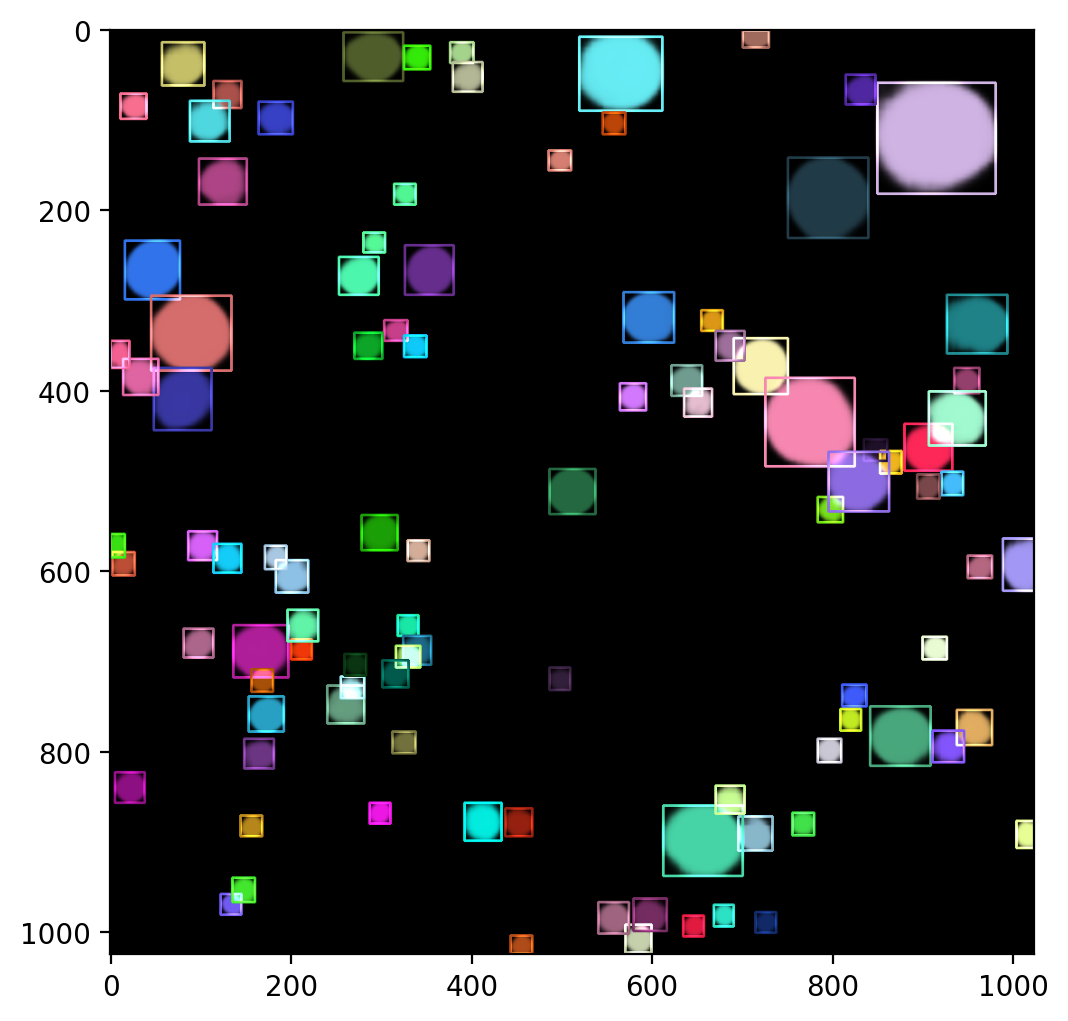

In [133]:
img = np.zeros( ( image_height, image_width, 3 ) )

for bbox, mask in zip( p[0]['boxes'].numpy(), p[0]['masks'].numpy() ):
    color = ( np.random.rand(), np.random.rand(), np.random.rand() )

    # Plot bounding box:
    cv2.rectangle(
        img,
        ( int( bbox[0] ), int( bbox[1] ) ),
        ( int( bbox[2] ), int( bbox[3] ) ),
        color,
        2,
    )

    # Apply color to mask
    mask = cv2.merge( ( mask * color[0], mask * color[1], mask * color[2] ) )
    
    img[:,:,:] += mask[0]
plt.imshow( img )
plt.show()

In [22]:
img = np.zeros( ( image_height, image_width, 3 ) )

index = 0

ellipses_from_contour = []

for bbox, mask in zip( p[index]['boxes'].numpy(), p[index]['masks'].numpy() ):
    color = ( np.random.rand(), np.random.rand(), np.random.rand() )

    # Plot bounding box:
    cv2.rectangle(
        img,
        ( int( bbox[0] ), int( bbox[1] ) ),
        ( int( bbox[2] ), int( bbox[3] ) ),
        color,
        2,
    )

    # Fit ellipse
    im = mask[0]
    im = np.array( np.round( im ), dtype = np.uint8 )
    threshold = 0.5
    canny_output = cv2.Canny( cv2.merge( ( im, im, im ) ), threshold, threshold * 2 )
    contours, _ = cv2.findContours( canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE ) 

    # print( contours[0].shape )
    # print( contours[1].shape )
    
    for contour in contours:
        # Hopefully only ever one!
        if contour.shape[0] > 5:
            e = cv2.fitEllipse( contour )
            ellipses_from_contour.append( e )
            
            cv2.ellipse( 
                img,
                ( int( e[0][0] ), int( e[0][1] ) ), # Center point
                ( int( e[1][0] / 2 ), int( e[1][1] / 2 ) ), # Major and minor axes
                float( e[2] ), # Convert angle from radians to degrees
                0, # Start Angle for drawing
                360, # End Angle for drawing
                color,
                2,
            )
        break
    
plt.imshow( img )
plt.show()

KeyError: 'masks'

In [149]:
print( len( p[index]['boxes'].numpy() ) )
print( len( p[index]['masks'].numpy() ) )

print( len( ellipses_from_contour ) )

100
100
100


In [14]:
targets = []

with torch.no_grad():
    bar = tq( data_loader_test, desc = f"Test Predictions" )
    
    for batch, ( images, targets_batch ) in enumerate( bar, 1 ):
        targets_batch = [ { k: v.to( torch.device( 'cpu' ) ) for k, v in d.items() } for d in targets_batch ]

        # Delete masks from target to save memory
        for t in targets_batch:
            del t['masks']
        
        targets.extend( targets_batch )

Test Predictions: 100%|██████████| 84/84 [00:21<00:00,  3.89it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


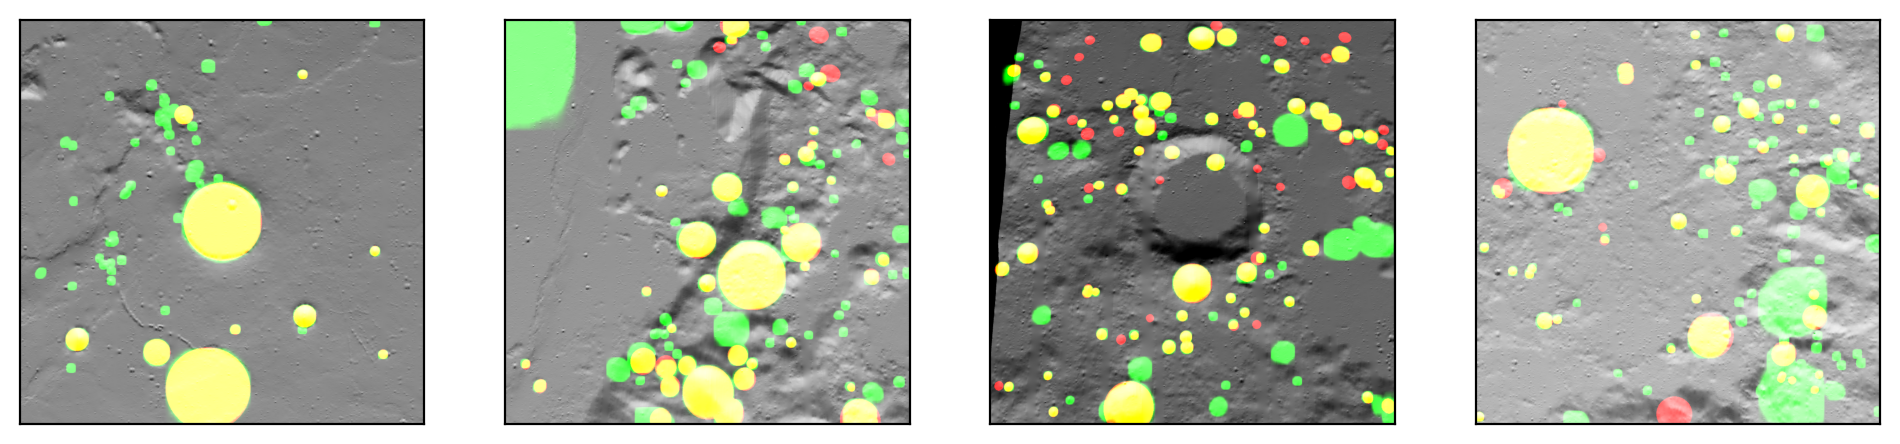

In [26]:
# Show a random sample of images
n_samples = 4
fig, ax = plt.subplots( ncols = n_samples )

for i in range( n_samples ):
    pred_index = int( np.random.rand() * len( predictions ) )
    img, target = dataset_test.__getitem__( pred_index )
    img = img.numpy()[0]
    img = np.stack( ( img, img, img ), axis = 2 )

    for mask in target['masks']:
        img[:,:,0] += mask.numpy()

    for mask in predictions[pred_index]['masks']:
        img[:,:,1] += mask.numpy()[0]

    # Red is False Negative
    # Green is False Positive
    # Yellow is True Positive
    
    ax[i].imshow( img )
    ax[i].set_xticks( [] )
    ax[i].set_yticks( [] )
    # ax[i].set_title( 'Angle: {angle:d}, Sample: {sample:d}'.format( angle = target['view_angle'][0].item(), sample = target['image_id'].item() ) )
plt.show()

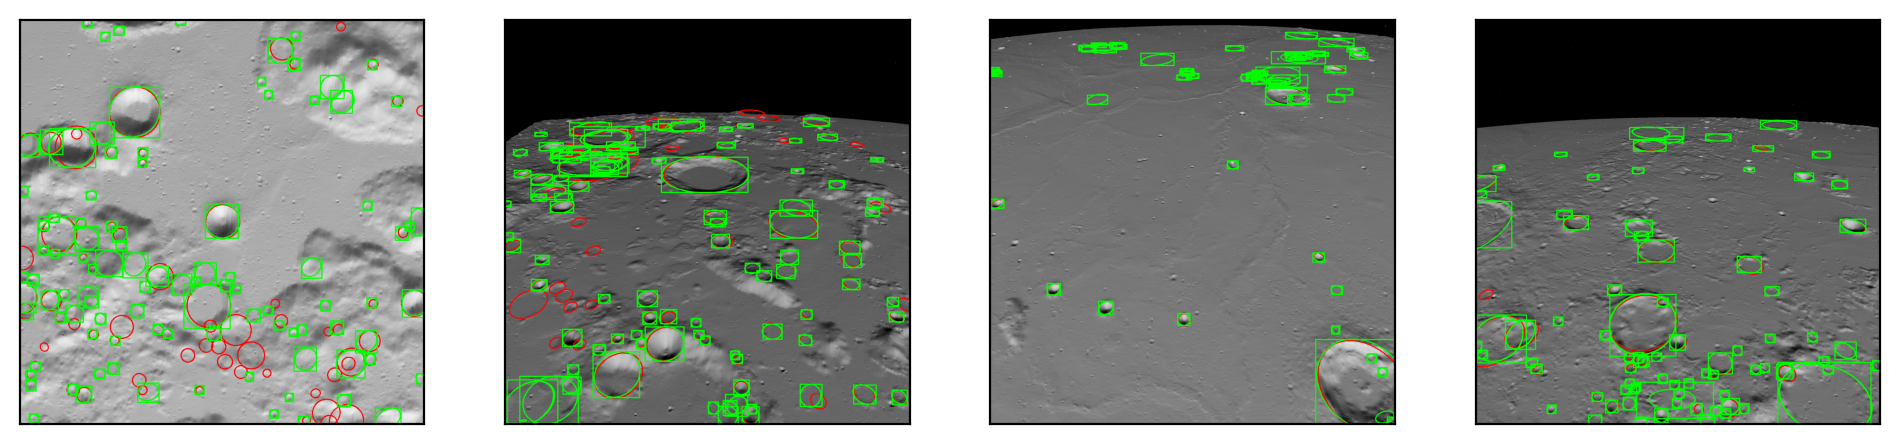

In [108]:
# Show a random sample of images
n_samples = 4
fig, ax = plt.subplots( ncols = n_samples )

for i in range( n_samples ):
    pred_index = int( np.random.rand() * len( predictions ) )
    img, target = dataset_test.__getitem__( pred_index )
    img = img.numpy()[0]
    img = np.stack( ( img, img, img ), axis = 2 )

    color = ( 1, 0, 0 )
    for ellipse in target['ellipse_sparse']:
        # Plot ellipse:
        cv2.ellipse( 
            img,
            ( int( ellipse[0] ), int( ellipse[1] ) ), # Center point
            ( int( ellipse[2] ), int( ellipse[3] ) ), # Major and minor axes
            float( ellipse[4] * 180 / math.pi ), # Convert angle from radians to degrees
            0, # Start Angle for drawing
            360, # End Angle for drawing
            color,
            2,
        )

    color = ( 0, 1, 0 )
    for ellipse in predictions[pred_index]['ellipse_sparse']:
        # Plot ellipse:
        cv2.ellipse( 
            img,
            ( int( ellipse[0] ), int( ellipse[1] ) ), # Center point
            ( int( ellipse[2] / 2 ), int( ellipse[3] / 2 ) ), # Major and minor axes
            float( ellipse[4] * 180 / math.pi ), # Convert angle from radians to degrees
            0, # Start Angle for drawing
            360, # End Angle for drawing
            color,
            2,
        )

    for bbox in predictions[pred_index]['boxes']:
        # Plot bounding box:
        cv2.rectangle(
            img,
            ( int( bbox[0] ), int( bbox[1] ) ),
            ( int( bbox[2] ), int( bbox[3] ) ),
            color,
            2,
        )

    # Red is False Negative
    # Green is False Positive
    # Yellow is True Positive
    
    ax[i].imshow( img )
    ax[i].set_xticks( [] )
    ax[i].set_yticks( [] )
    # ax[i].set_title( 'Angle: {angle:d}, Sample: {sample:d}'.format( angle = target['view_angle'][0].item(), sample = target['image_id'].item() ) )
plt.show()

In [74]:
results = []

for confidence_threshold in np.concatenate( ( np.arange( 0.01, 0.1, 0.01 ), np.arange( 0.1, 0.9, 0.1 ), np.arange( 0.9, 1.0, 0.01 ) ), axis = 0 ):
    confident_predictions = []
    for prediction in predictions:
        indices = ( prediction['scores'] > confidence_threshold ).nonzero().flatten()
        
        confident_predictions.append( {
            'boxes': prediction['boxes'][indices],
            'scores': prediction['scores'][indices],
            'labels': prediction['labels'][indices],
        } )

    for IoU_threshold in np.arange( 0.5, 1, 0.05 ):
        tp = 0
        true_boxes = 0
        pred_boxes = 0

        for pred, target in zip( confident_predictions, targets ):
            if len( target['boxes'].shape ) < 2:
                # No craters in image
                pred_boxes += pred['boxes'].shape[0]
            else:
                iou = box_iou( pred['boxes'], target['boxes'] )
                iou_masked = iou > IoU_threshold

                tp += iou_masked.any( axis = 0 ).sum()
                true_boxes += iou_masked.shape[1]
                pred_boxes += iou_masked.shape[0]

        results.append( {
            'detections_per_image': tp.item() / len( targets ),
            'confidence_threshold': confidence_threshold,
            'IoU_threshold': IoU_threshold,
            'precision': ( tp / pred_boxes ).item(),
            'recall': ( tp / true_boxes ).item()
        } )

        print( confidence_threshold, IoU_threshold, end = '\r' )

In [75]:
results = pd.DataFrame( results )
results['f1_score'] = ( 2 * results['precision'] * results['recall'] ) / ( results['precision'] + results['recall'] )

print( 'Performance where F1 score was maximised:' )
print( results.iloc[results['f1_score'].argmax()] )

display( results )

Performance where F1 score was maximised:
detections_per_image    31.586466
confidence_threshold     0.700000
IoU_threshold            0.500000
precision                0.786940
recall                   0.655178
f1_score                 0.715039
Name: 150, dtype: float64


,detections_per_image,confidence_threshold,IoU_threshold,precision,recall,f1_score
0,36.669173,0.01,0.50,0.431379,0.760605,0.550526
1,36.132331,0.01,0.55,0.425064,0.749470,0.542466
2,35.341353,0.01,0.60,0.415759,0.733063,0.530591
3,34.106767,0.01,0.65,0.401235,0.707455,0.512056
4,32.206015,0.01,0.70,0.378874,0.668029,0.483519
...,...,...,...,...,...,...
265,12.884211,0.99,0.75,0.968792,0.267249,0.418932
266,12.230075,0.99,0.80,0.919607,0.253681,0.397663
267,10.586466,0.99,0.85,0.796020,0.219588,0.344221
268,6.637594,0.99,0.90,0.499095,0.137679,0.215822


In [16]:
best_confidence_threshold = 0.7

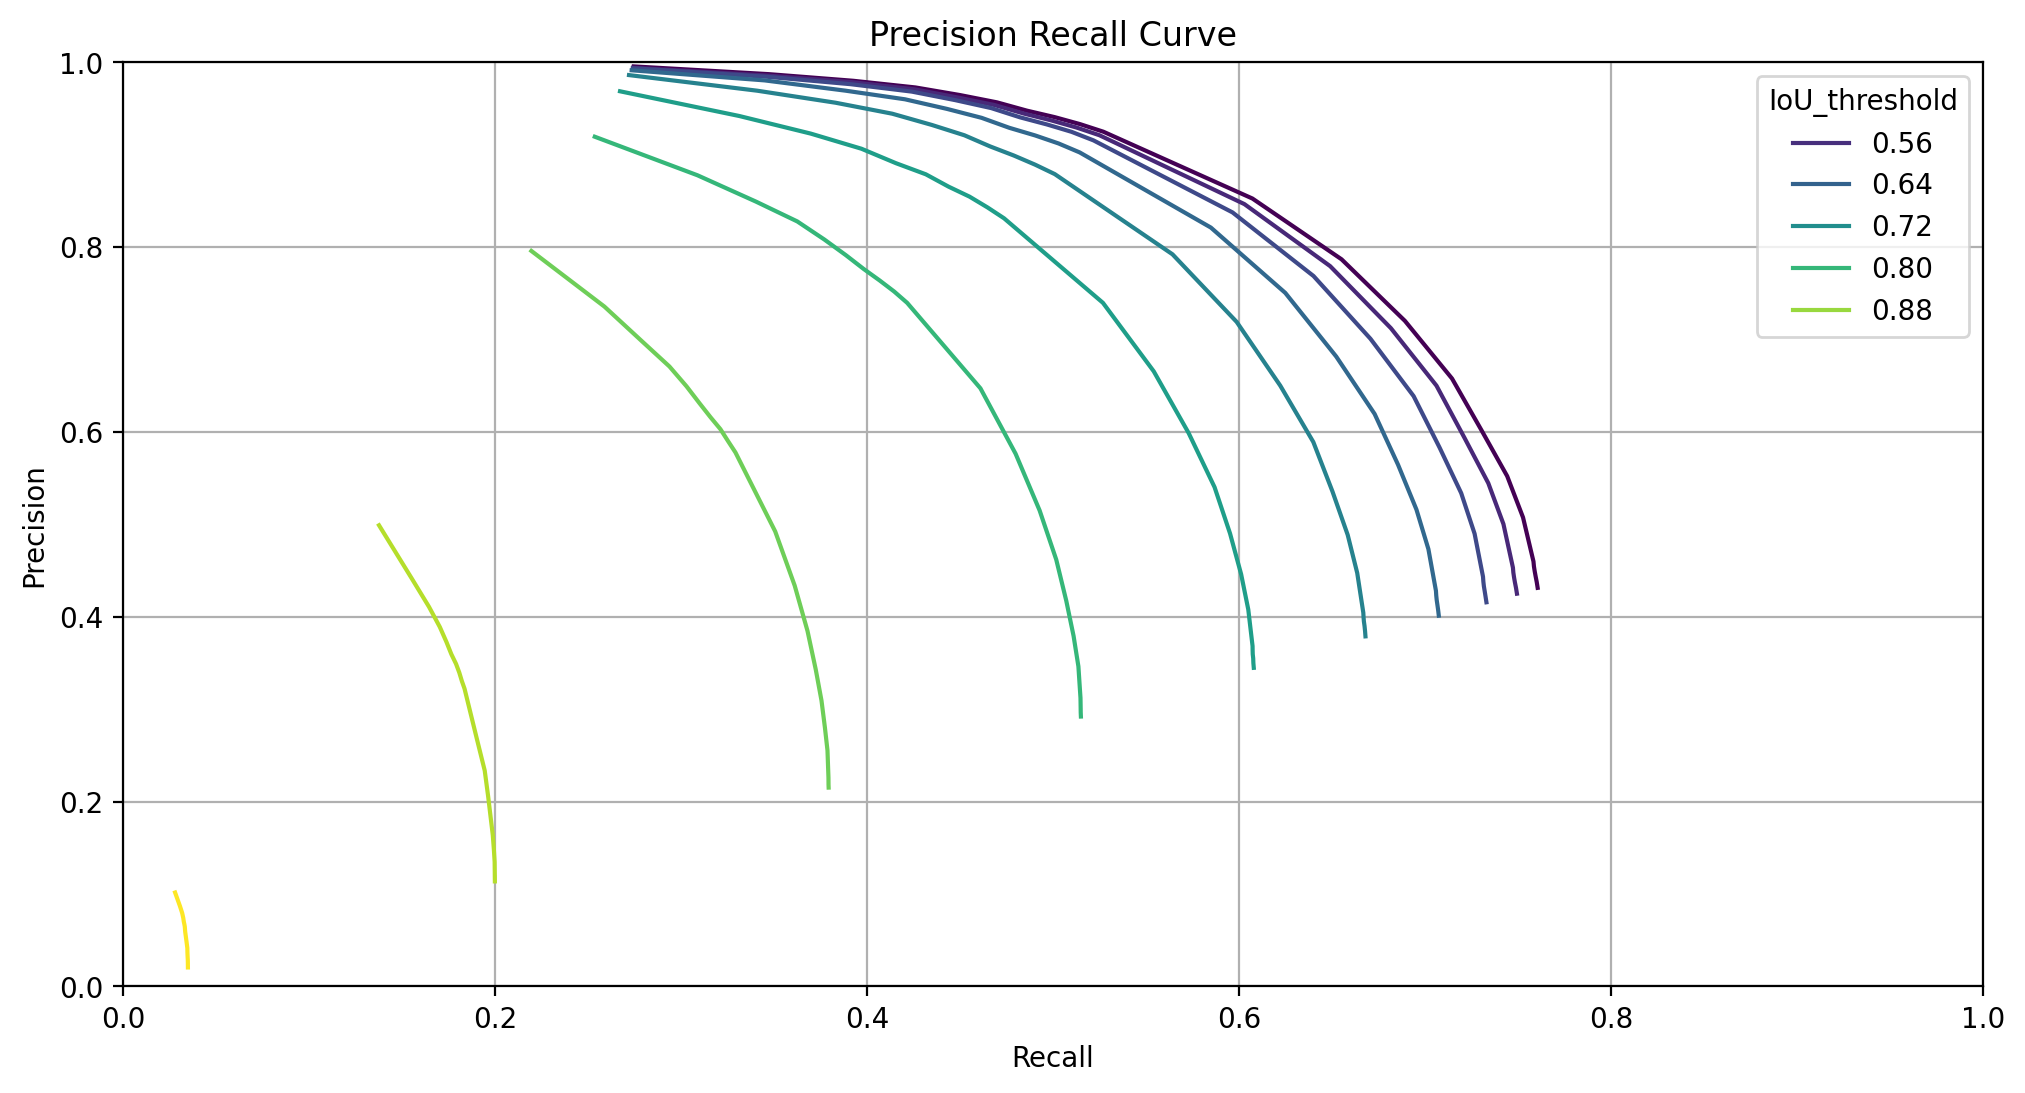

In [77]:
sns.lineplot(
    data = results,
    x = 'recall',
    y = 'precision',
    hue = 'IoU_threshold',
    # hue = 'confidence_threshold',
    palette = 'viridis',
)
plt.title( 'Precision Recall Curve')
plt.xlabel( 'Recall' )
plt.ylabel( 'Precision' )
plt.ylim( 0, 1 )
plt.xlim( 0, 1 )
plt.grid()
plt.show()

In [18]:
from pangu_dataset_mask import evaluate_ellipse

In [19]:
ellipse_matches = []

confidence_thresholds = [ best_confidence_threshold ]
IoU_thresholds = [ 0.5 ]

for confidence_threshold in confidence_thresholds:
    confident_predictions = []
    for prediction in predictions:
        indices = ( prediction['scores'] > confidence_threshold ).nonzero().flatten()

        # Process ellipses
        e = np.array( prediction['ellipse_sparse'] )[indices]
        e[:,2] /= 2
        e[:,3] /= 2

        confident_predictions.append( {
            'boxes': prediction['boxes'][indices],
            'scores': prediction['scores'][indices],
            'labels': prediction['labels'][indices],
            'ellipse_sparse': e,
        } )
    
    for IoU_threshold in IoU_thresholds:
        tp = 0
        true_boxes = 0
        pred_boxes = 0

        for i, ( pred, target ) in enumerate( zip( confident_predictions, targets ) ):
            print( i, end = '\r' )
            if len( target['boxes'].shape ) < 2:
                # No craters in image
                pred_boxes += pred['boxes'].shape[0]
            else:
                iou = box_iou( pred['boxes'], target['boxes'] )
                iou_masked = iou > IoU_threshold
                indices = ( iou_masked == True ).nonzero( as_tuple = True )

                for pred_index, true_index in zip( indices[0], indices[1] ):
                    error = evaluate_ellipse(
                        pred['ellipse_sparse'][pred_index],
                        target['ellipse_sparse'][true_index].to( 'cpu' ).numpy()
                    )
                    
                    ellipse_matches.append( {
                        'confidence_threshold': confidence_threshold,
                        'IoU_threshold': IoU_threshold,
                        # 'view_angle': target['view_angle'].to( 'cpu' ).numpy()[0],
                        # 'depth': target['depths'][true_index].to( 'cpu' ).numpy(),
                        'pred': pred['ellipse_sparse'][pred_index],
                        'target': target['ellipse_sparse'][true_index].to( 'cpu' ).numpy(),
                    } | error )

        print( confidence_threshold, IoU_threshold, end = '\r' )

In [20]:
ellipse_matches = pd.DataFrame( ellipse_matches )
display( ellipse_matches )

,confidence_threshold,IoU_threshold,pred,target,x_error,y_error,a_error,b_error,theta_error,absolute_error,IoU
0,0.7,0.5,"[511.390625, 511.18414306640625, 25.8731517791...","[512.0028, 512.0015, 26.097761, 26.097761, 0.9...",0.612183,0.817383,0.224609,1.273268,0.345015,3.272458,0.925634
1,0.7,0.5,"[47.604244232177734, 264.2344665527344, 30.183...","[48.36592, 266.3313, 31.555706, 30.898663, -1....",0.761677,2.096832,1.372364,2.679127,1.643509,8.553509,0.892467
2,0.7,0.5,"[720.4618530273438, 372.41790771484375, 29.643...","[720.6859, 373.66425, 29.970139, 29.826551, 0....",0.224060,1.246338,0.326212,0.942528,0.589896,3.329034,0.953857
3,0.7,0.5,"[173.97804260253906, 758.7957763671875, 19.208...","[174.39893, 758.905, 17.95092, 17.71355, 0.939...",0.420883,0.109253,1.257895,3.032793,0.211881,5.032705,0.763262
4,0.7,0.5,"[794.4818725585938, 186.1405487060547, 45.3597...","[794.7709, 183.68875, 44.79952, 44.14526, 0.71...",0.289001,2.451797,0.560192,1.949074,2.235043,7.485108,0.913542
...,...,...,...,...,...,...,...,...,...,...,...
21022,0.7,0.5,"[967.167724609375, 736.5940551757812, 32.15542...","[968.359, 735.2559, 67.62649, 32.988087, 0.372...",1.191284,1.338135,35.471062,30.238686,1.505405,69.744571,0.921494
21023,0.7,0.5,"[575.0357055664062, 432.96282958984375, 11.320...","[580.9371, 434.9928, 36.135677, 10.250676, 0.0...",5.901367,2.029968,24.815566,28.452857,1.565267,62.765026,0.750168
21024,0.7,0.5,"[985.6636962890625, 536.1124877929688, 9.04816...","[987.59186, 538.117, 30.212881, 9.373046, 0.24...",1.928162,2.004517,21.164712,19.943397,1.590878,46.631665,0.795339
21025,0.7,0.5,"[490.9698486328125, 529.9324951171875, 10.8238...","[491.94846, 530.8343, 24.0723, 10.243031, -0.0...",0.978607,0.901794,13.248457,14.264700,1.565562,30.959121,0.873126


In [98]:
predicted_ellipses = pd.DataFrame( ellipse_matches['pred'].to_list(), columns = [ 'x', 'y', 'a', 'b', 'angle' ] )
true_ellipses = pd.DataFrame( ellipse_matches['target'].to_list(), columns = [ 'x', 'y', 'a', 'b', 'angle' ] )

In [99]:
ellipse_matches['eccentricity'] = true_ellipses['b'] / true_ellipses['a']

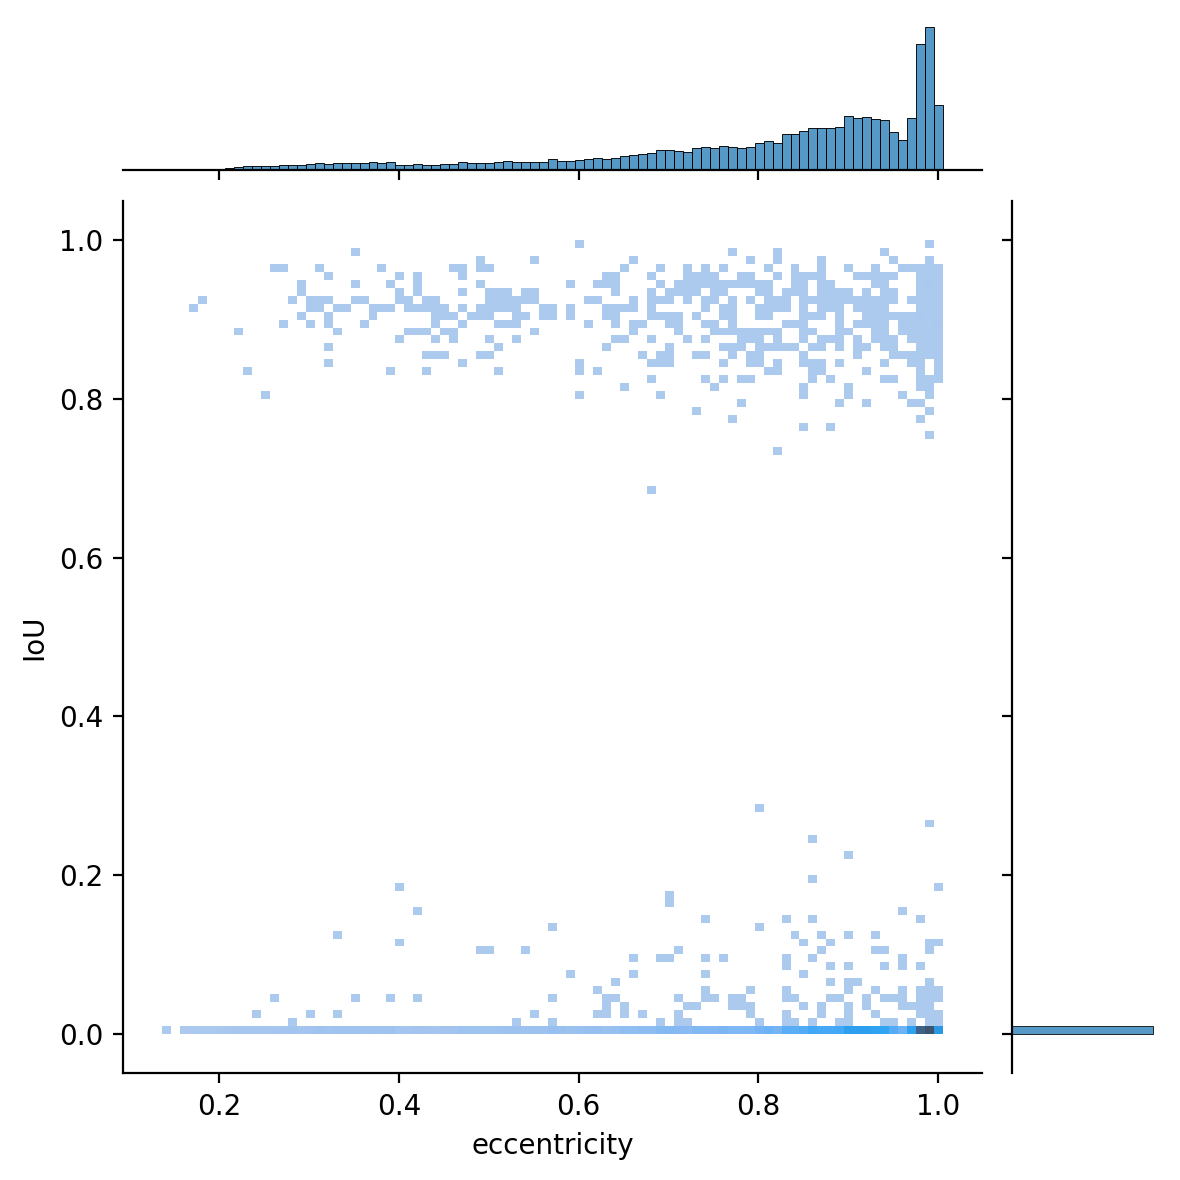

In [100]:
p = sns.jointplot(
    ellipse_matches,
    y = 'IoU',
    x = 'eccentricity',
    kind = 'hist',
    # alpha = 0.4,
    binwidth = ( 0.01, 0.01 ),
    # hue_norm = 'log',
)

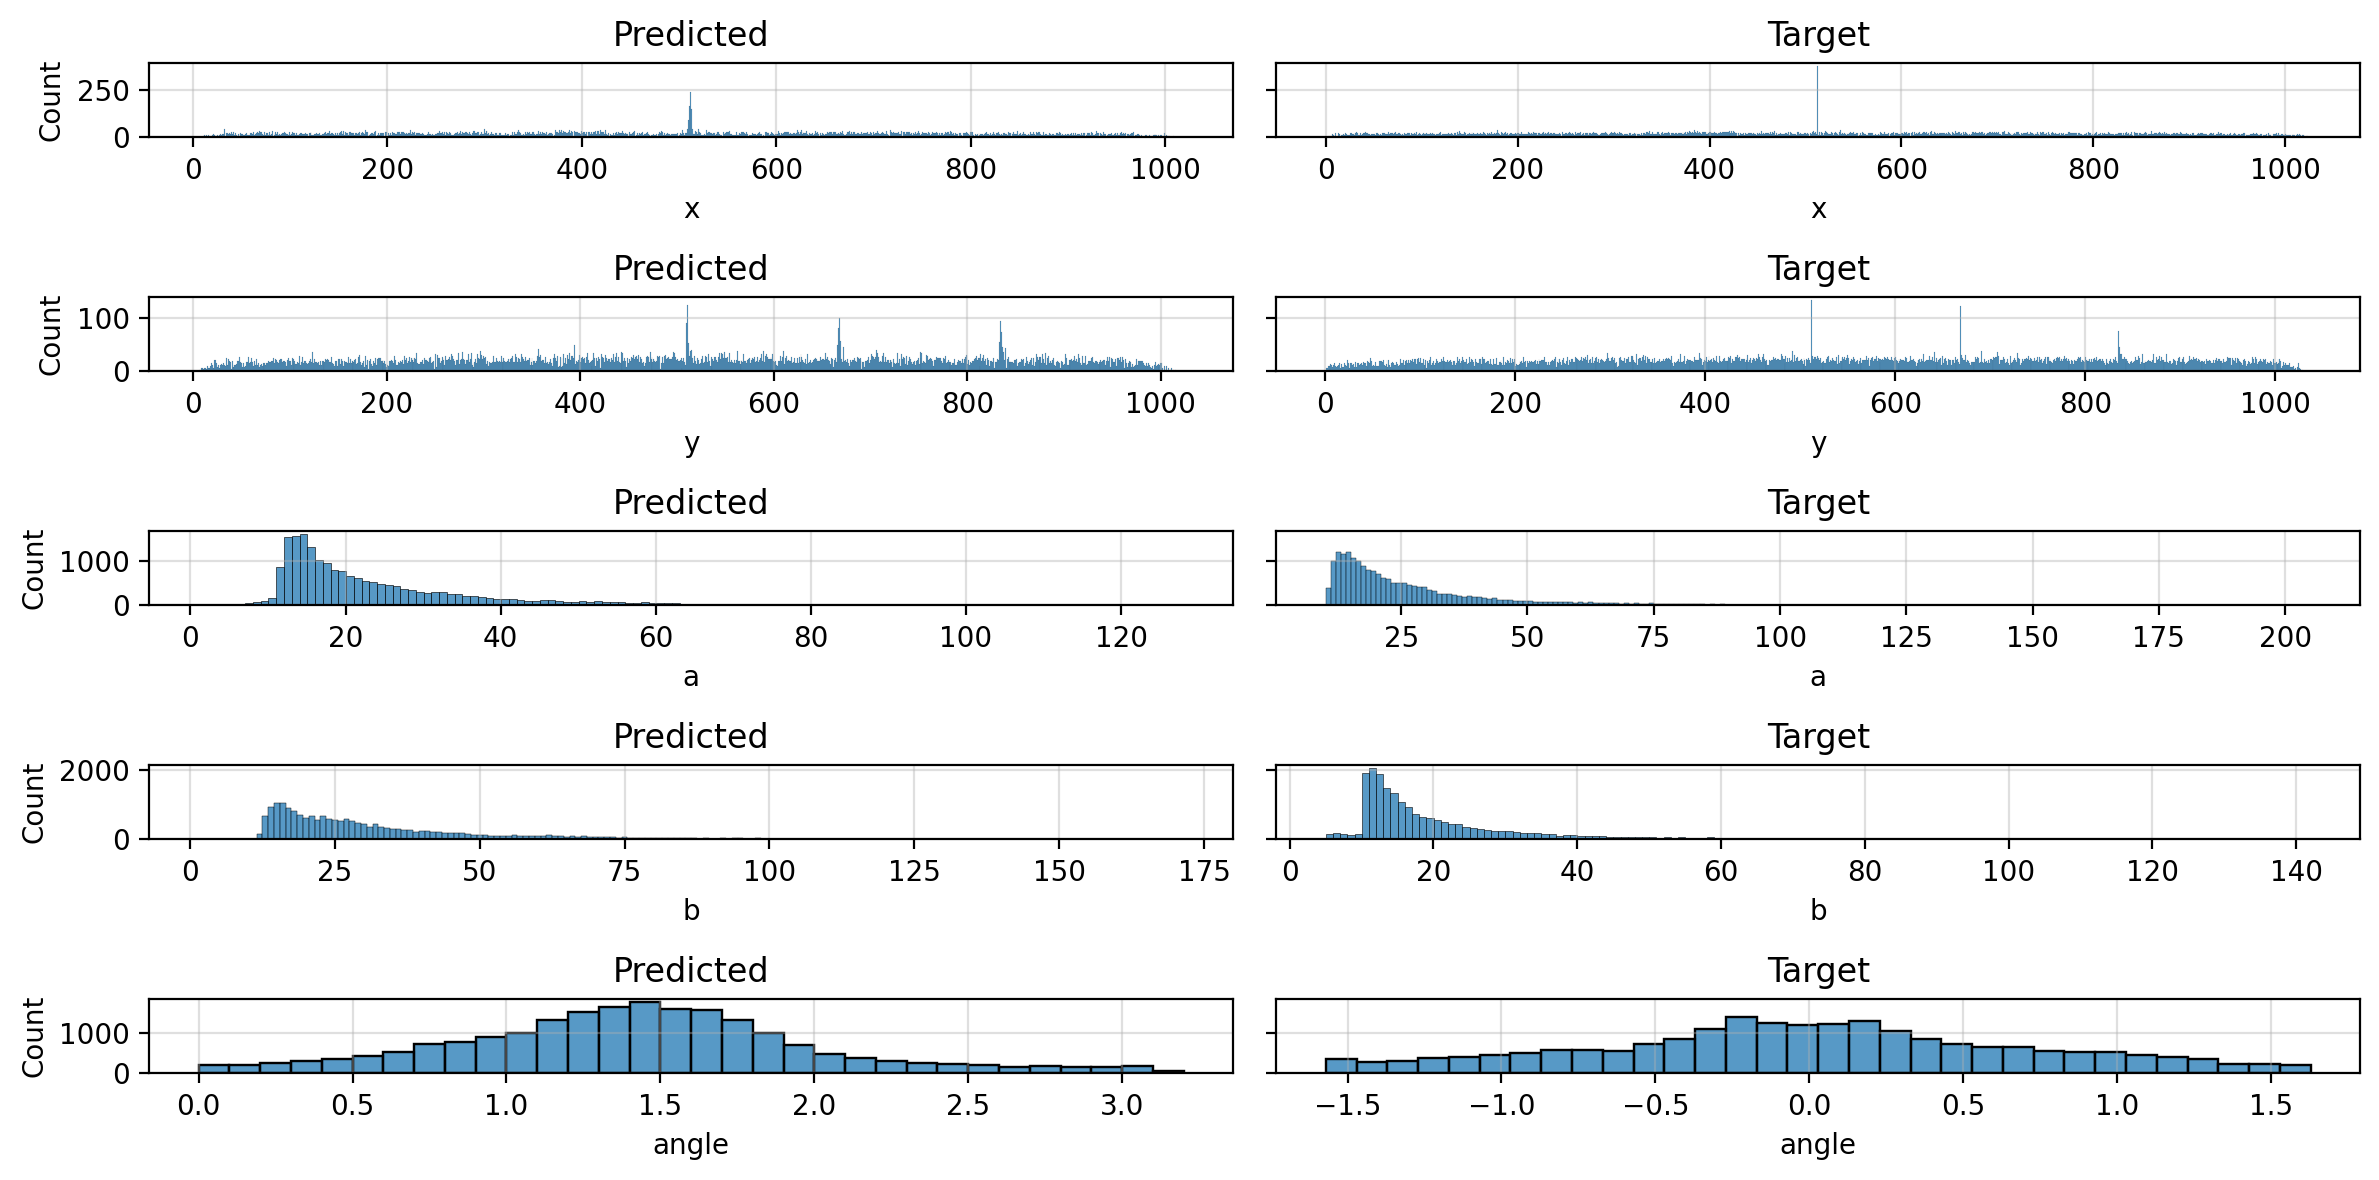

In [101]:
# Compare distribution of predicted and target ellipses
keys = [ 'x', 'y', 'a', 'b', 'angle' ]
bin_widths = [ 1, 1, 1, 1, 0.1 ]

fig, ax = plt.subplots( nrows = len( keys ), ncols = 2, sharey = 'row', figsize = ( 12, 6 ) )

for i, key in enumerate( keys ):
    p = sns.histplot(
        data = predicted_ellipses,
        ax = ax[i,0],
        x = key,
        binwidth = bin_widths[i],
    )
    p.grid( alpha = 0.4 )
    p.set_title( 'Predicted' )
    p.set_xlabel( key )
    
    p = sns.histplot(
        data = true_ellipses,
        ax = ax[i,1],
        x = key,
        binwidth = bin_widths[i],
    )
    p.grid( alpha = 0.4 )
    p.set_title( 'Target' )
    p.set_xlabel( key )

fig.tight_layout()
plt.show()

In [21]:
keys = [ 'x_error', 'y_error', 'a_error', 'b_error', 'theta_error', 'absolute_error', 'IoU' ]

print( 'Average error in matched ellipses' )
for key in keys:
    print( key, ':', round( ellipse_matches[key].mean(), 3 ) )

Average error in matched ellipses
x_error : 5.174
y_error : 4.274
a_error : 7.166
b_error : 7.238
theta_error : 1.511
absolute_error : 25.364
IoU : 0.823


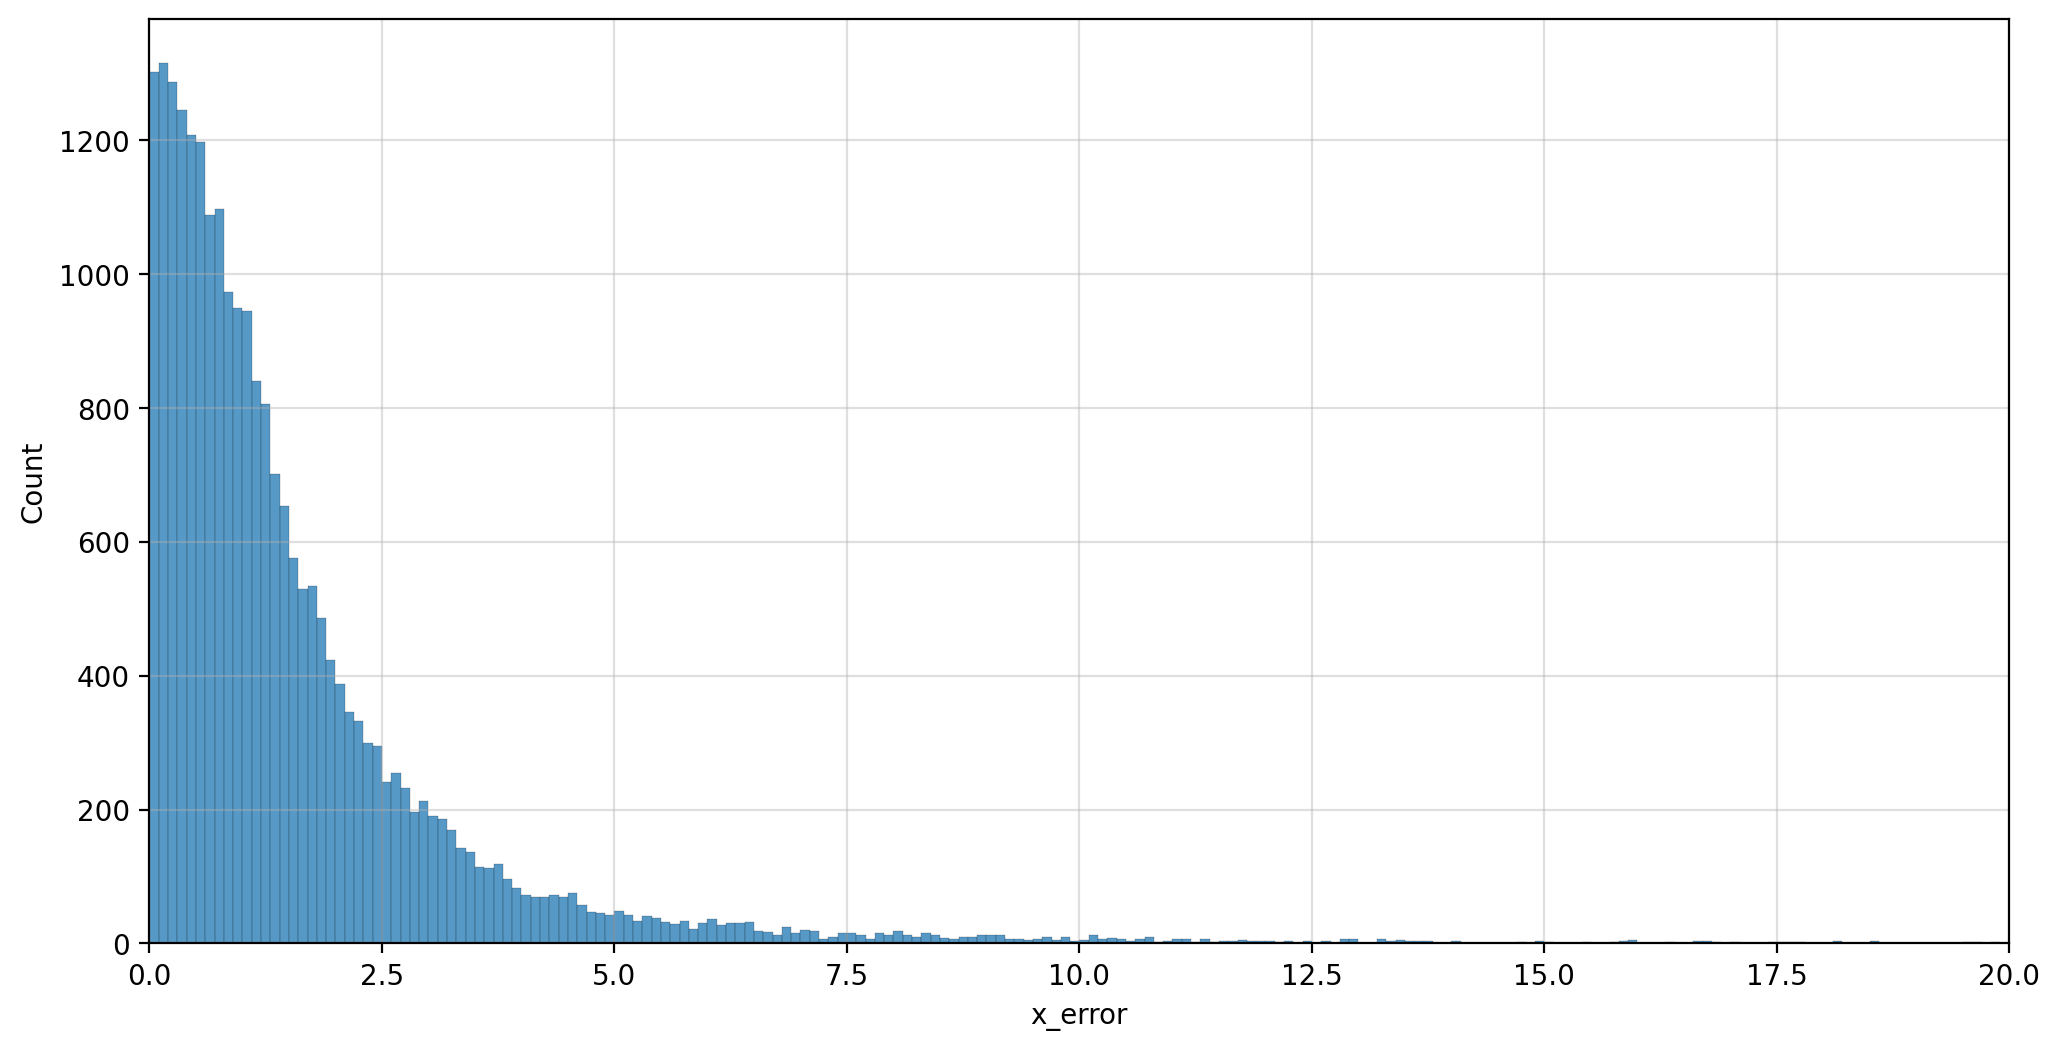

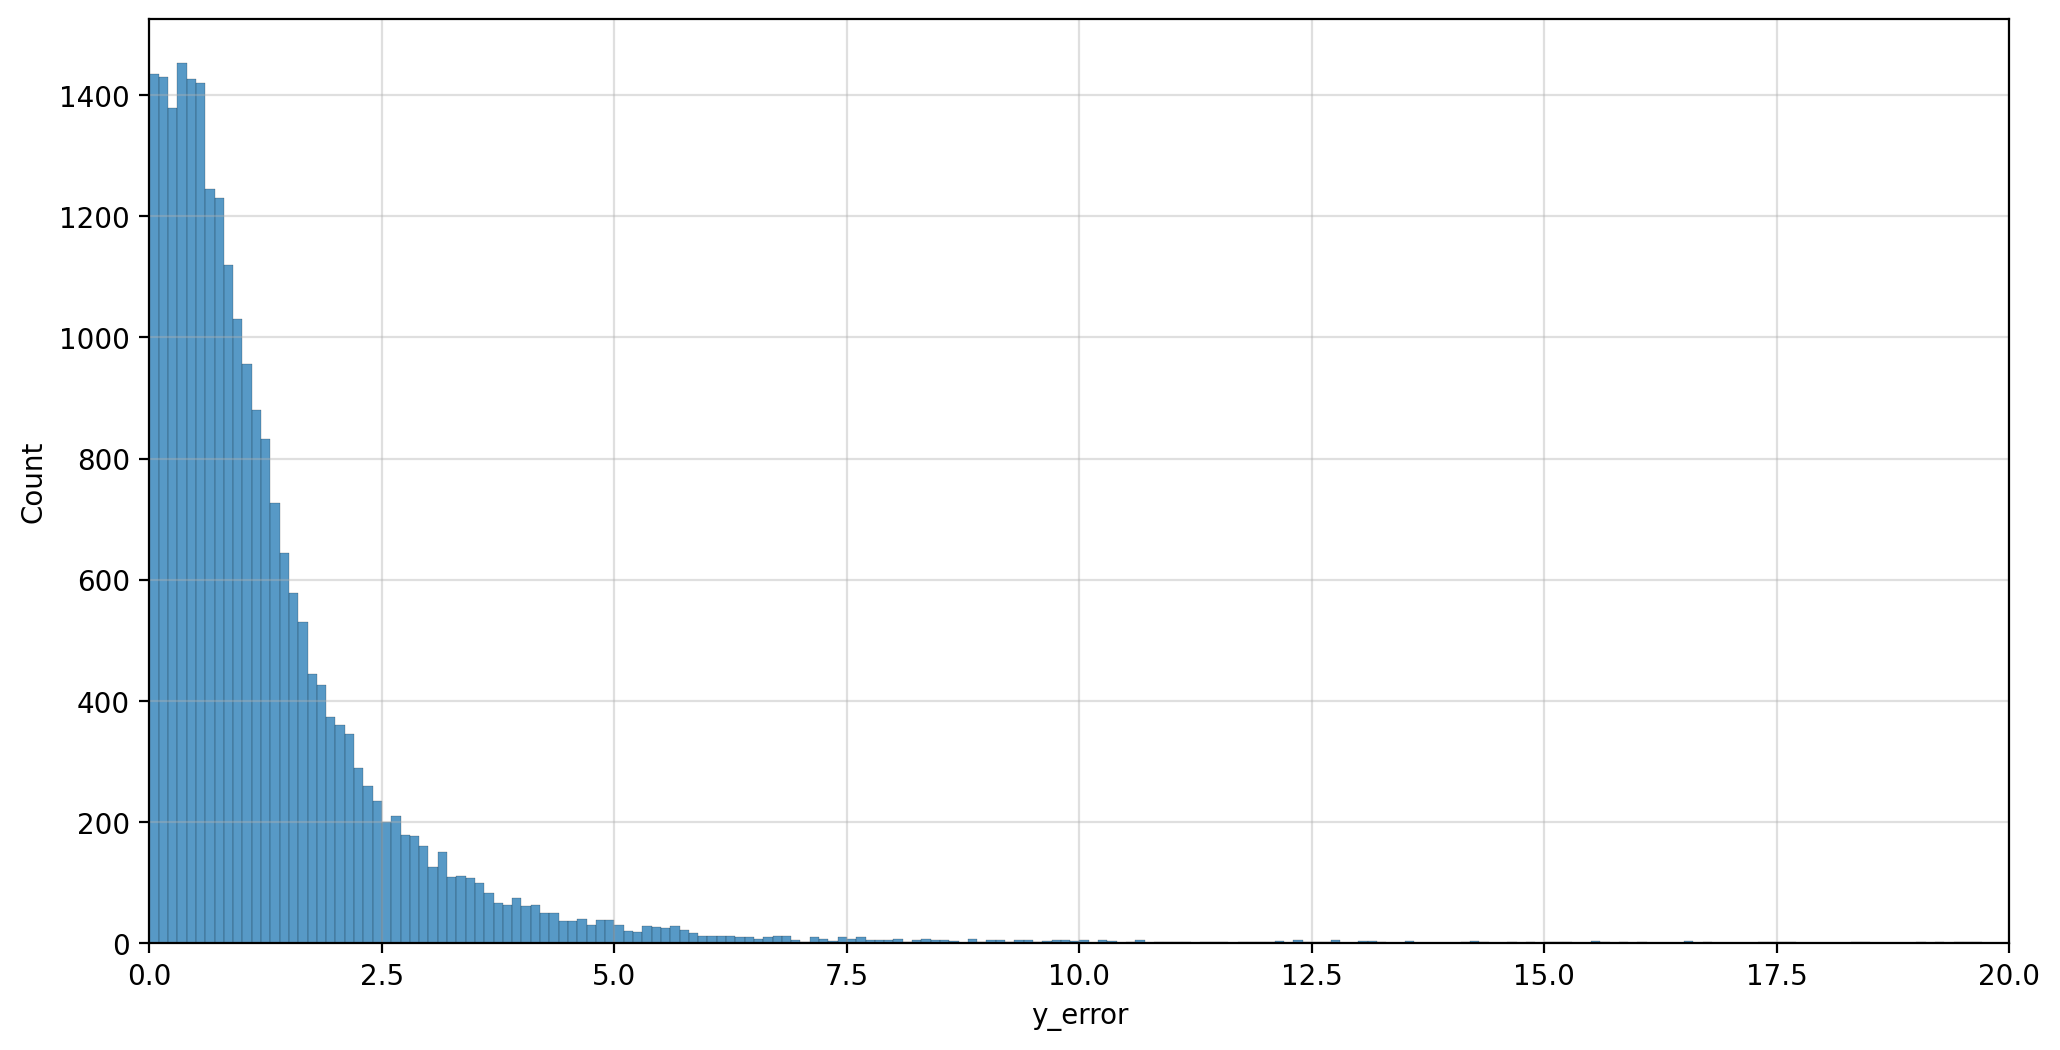

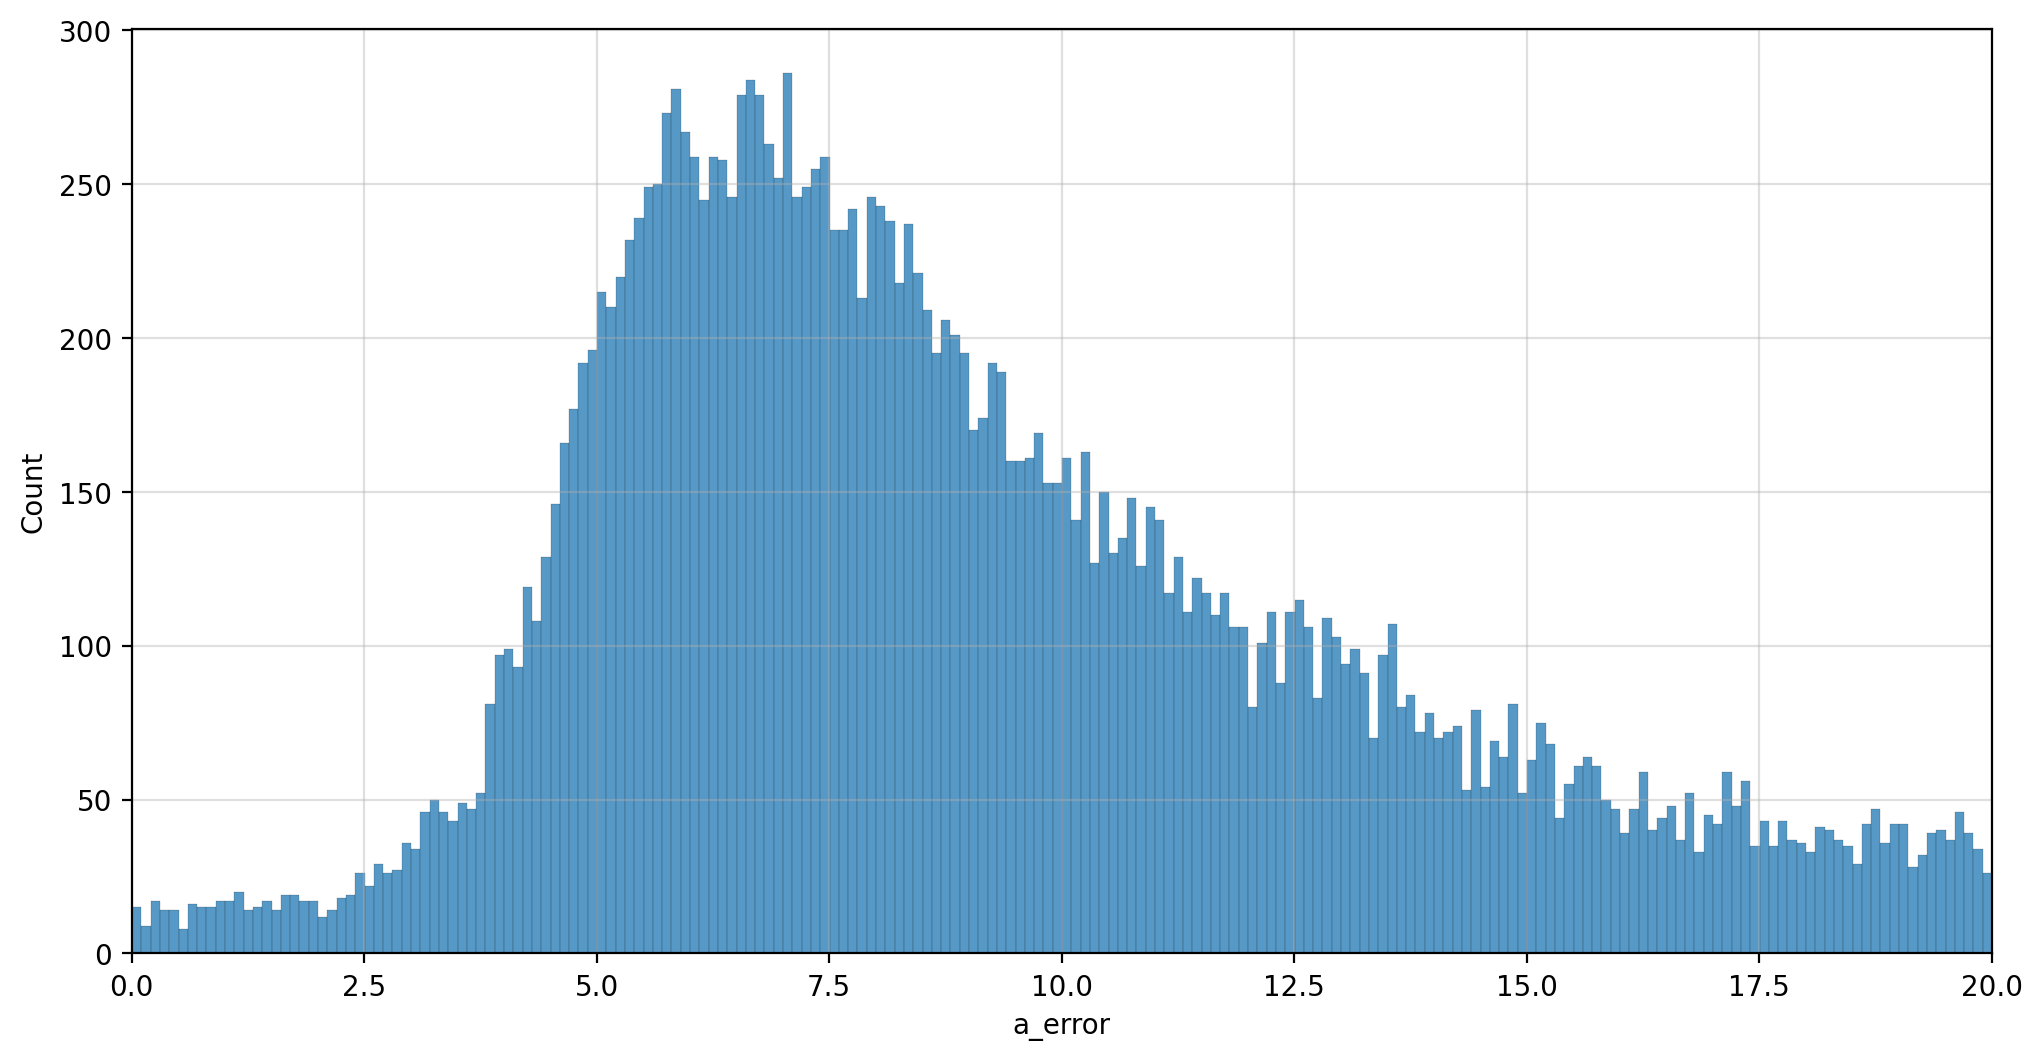

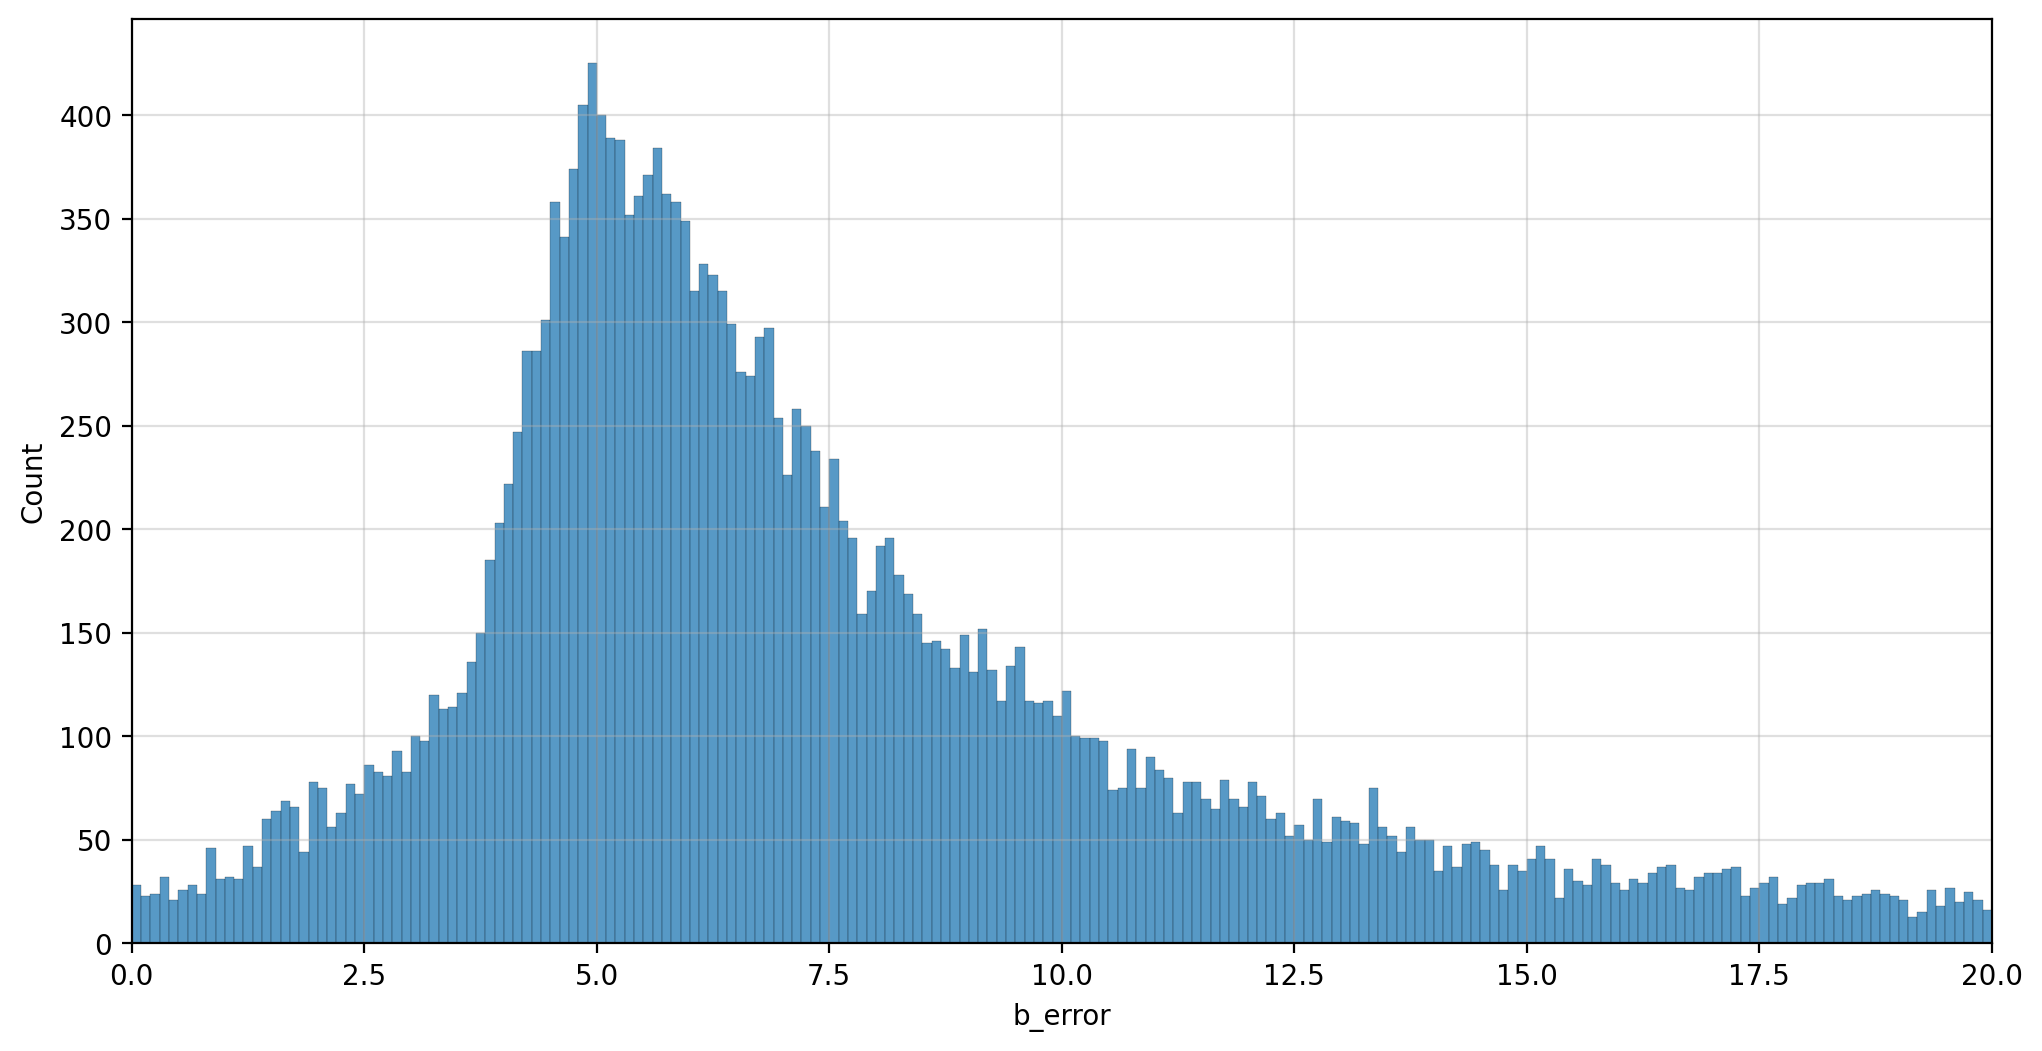

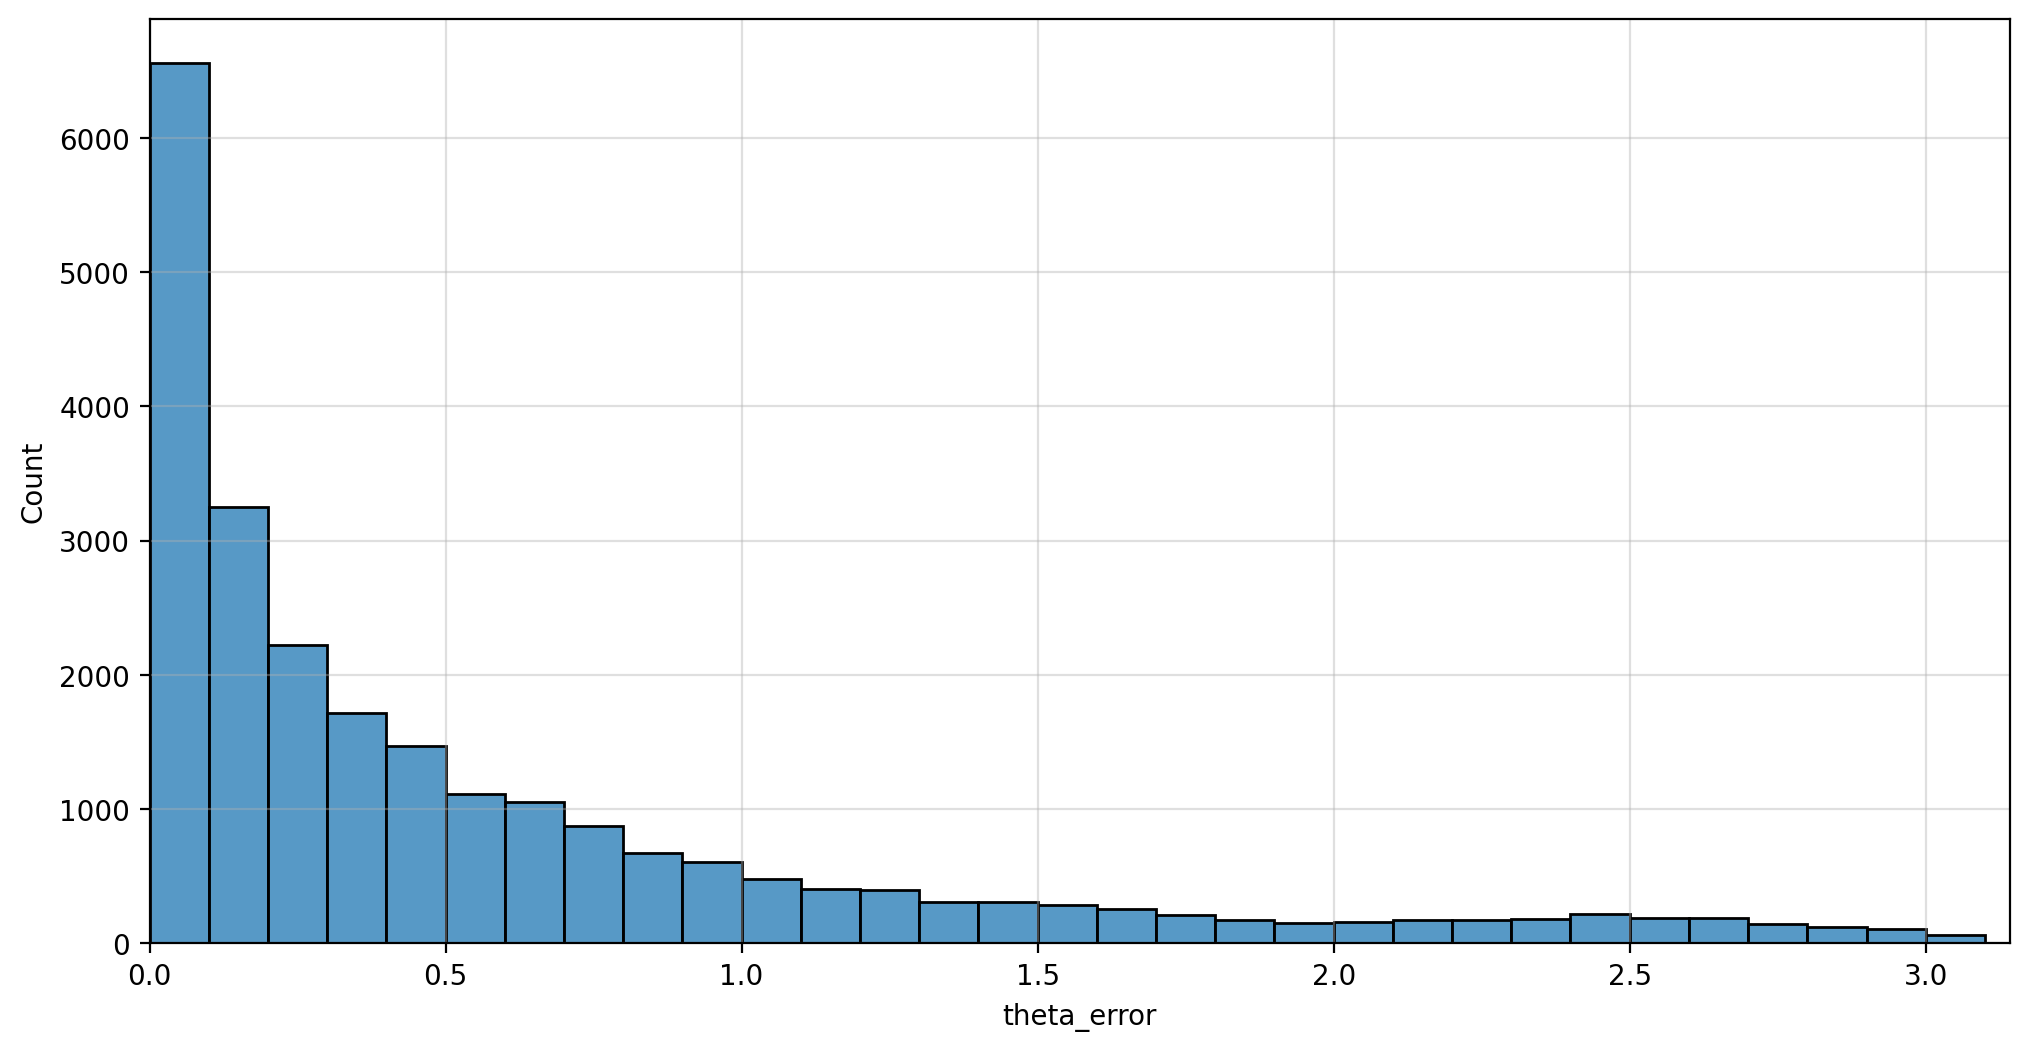

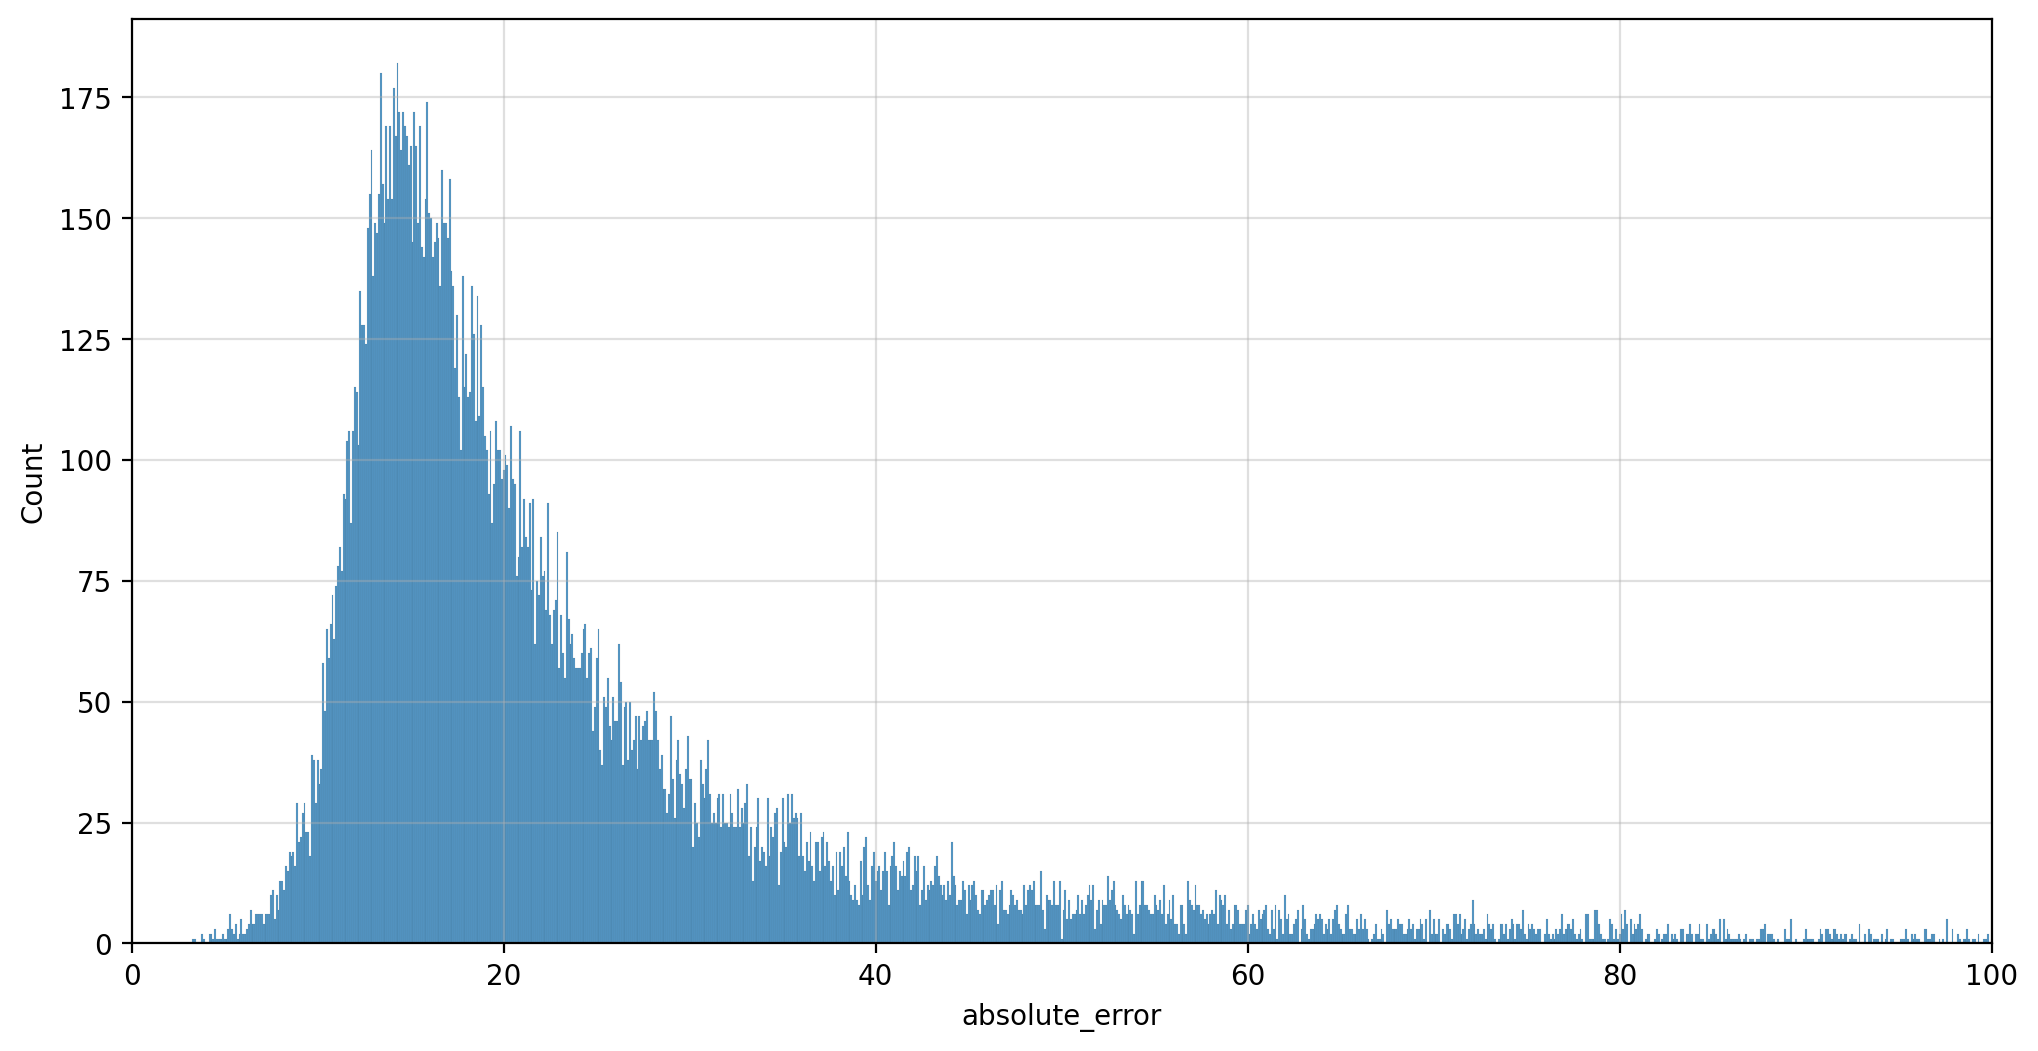

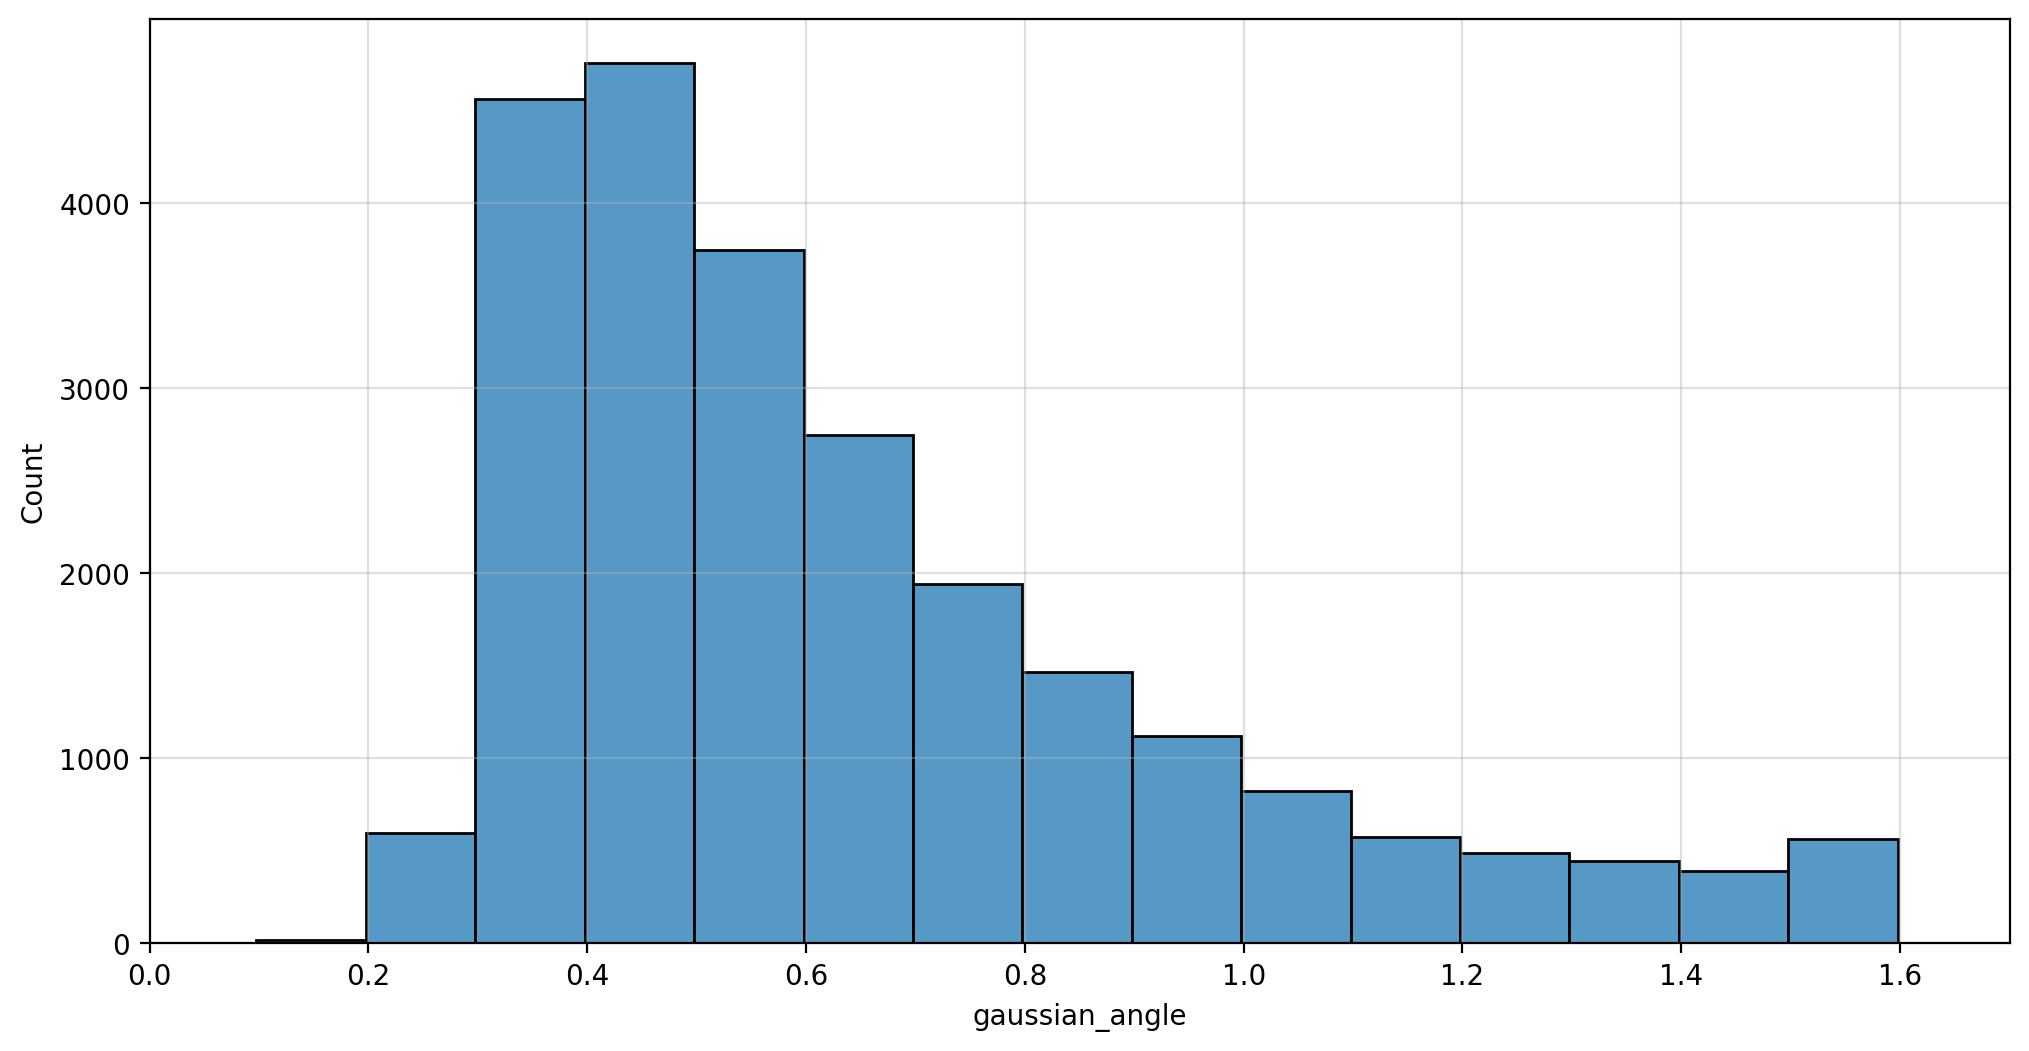

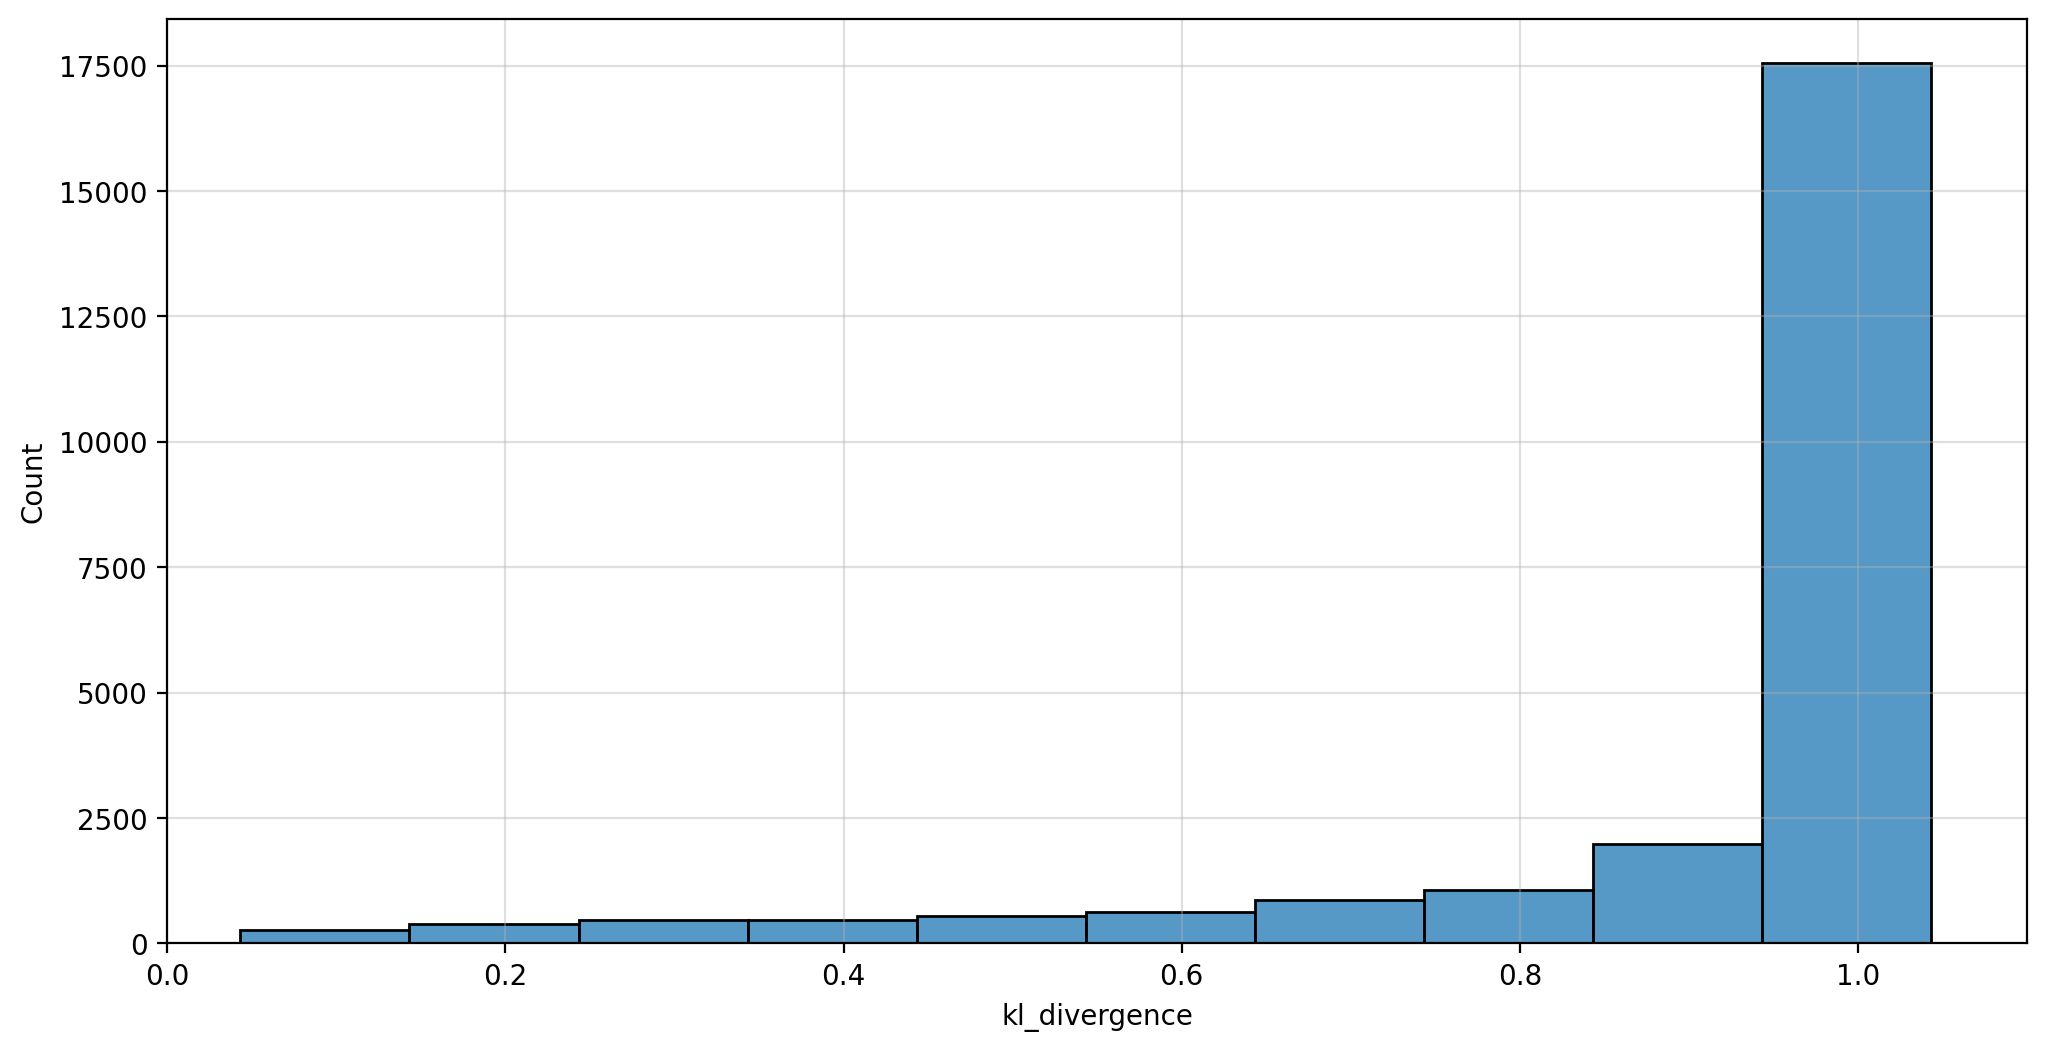

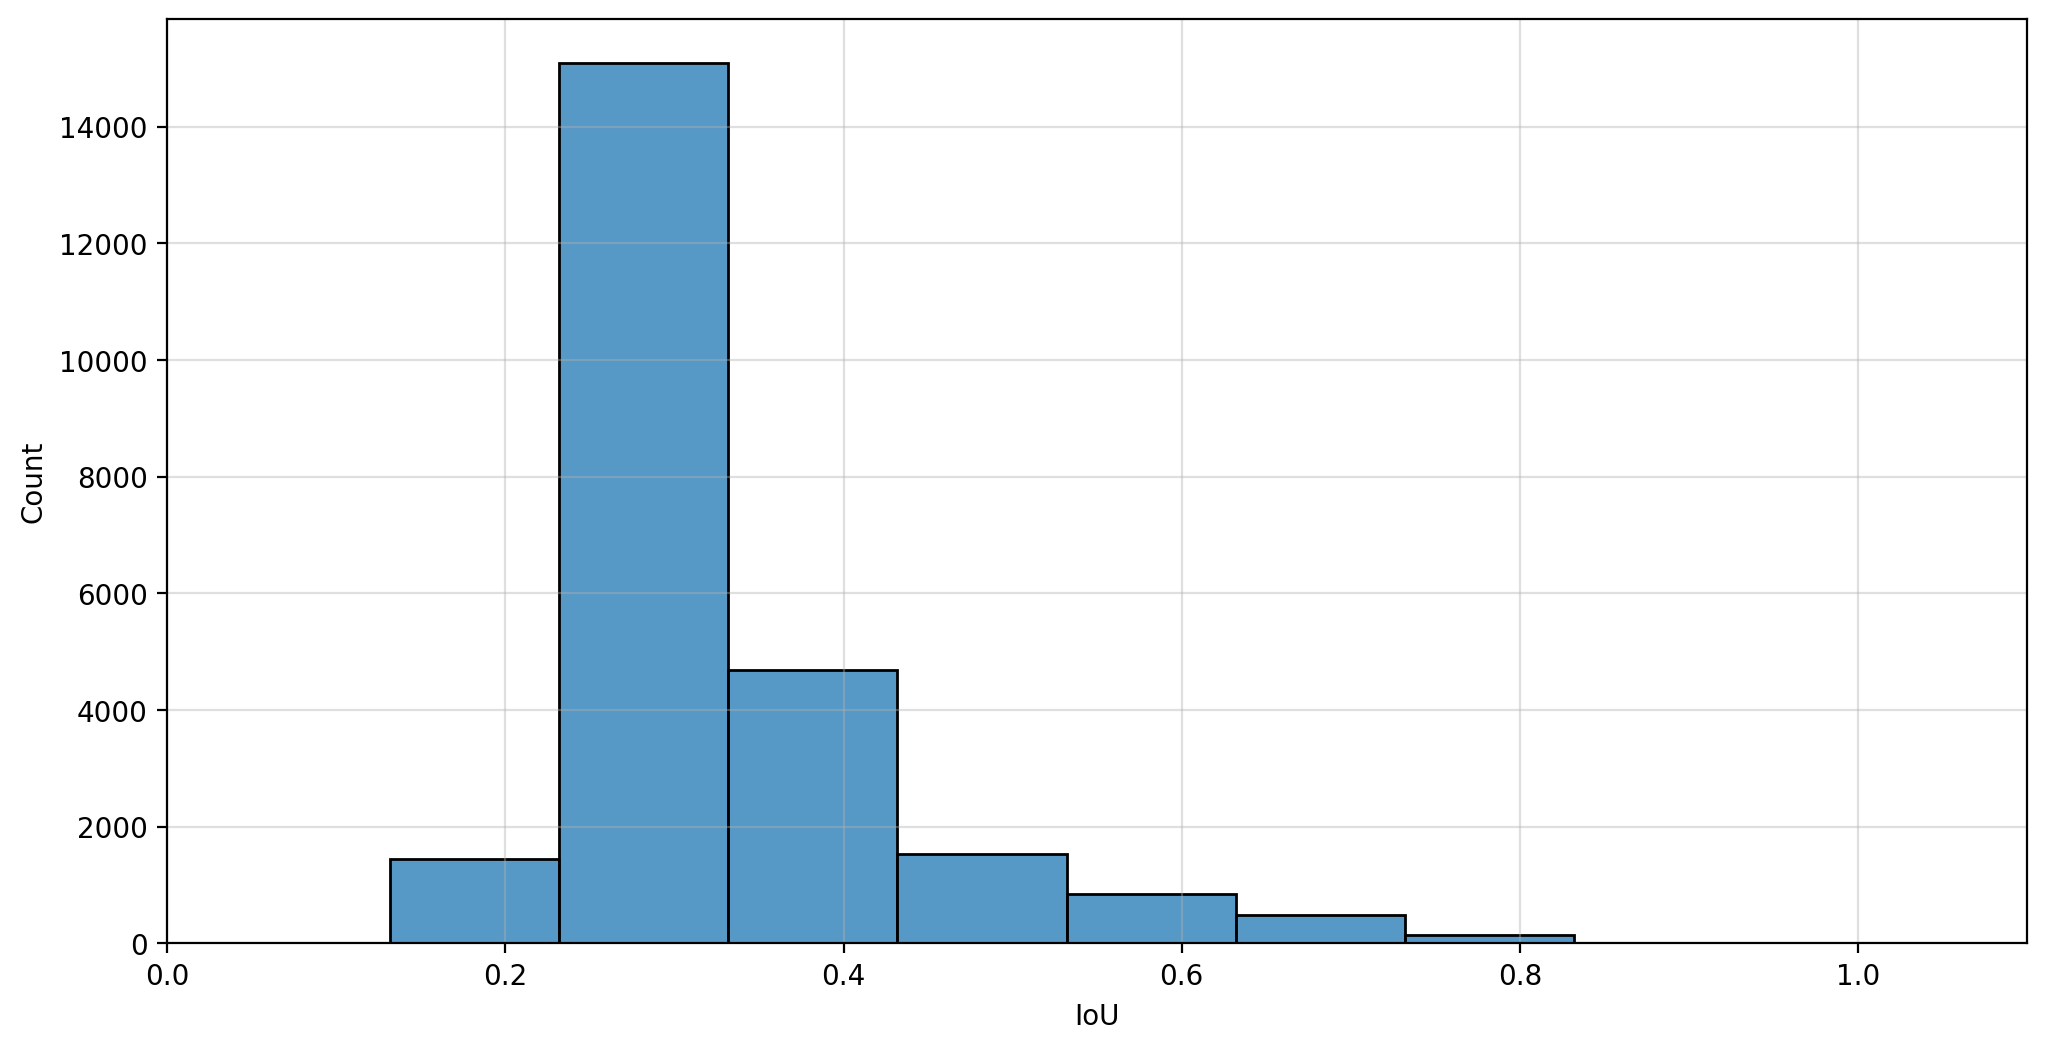

In [33]:
keys = [ 'x_error', 'y_error', 'a_error', 'b_error', 'theta_error', 'absolute_error', 'gaussian_angle', 'kl_divergence', 'IoU' ]
bin_widths = [ 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ]
xlims = [ 20, 20, 20, 20, math.pi, 100, 1.7, 1.1, 1.1 ]

for i, key in enumerate( keys ):
    p = sns.histplot(
        data = ellipse_matches,
        x = key,
        binwidth = bin_widths[i],
    )
    p.set_xlim( 0, xlims[i] )
    p.grid( alpha = 0.4 )
    plt.show()

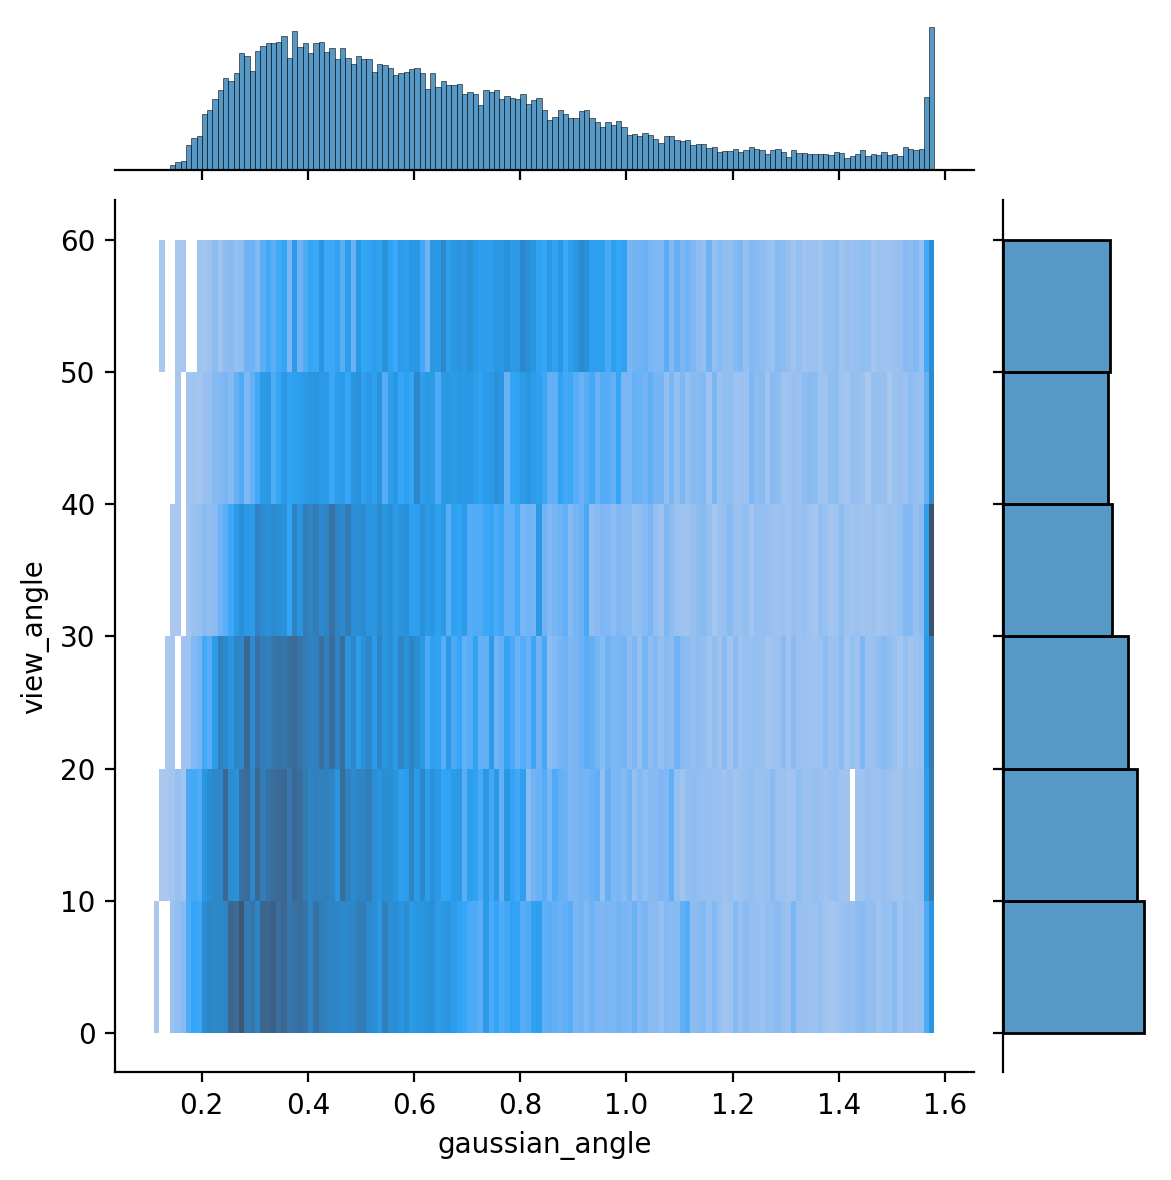

In [27]:
p = sns.jointplot(
    ellipse_matches,
    x = 'gaussian_angle',
    y = 'view_angle',
    kind = 'hist',
    binwidth = ( 0.01, 10 ),
)

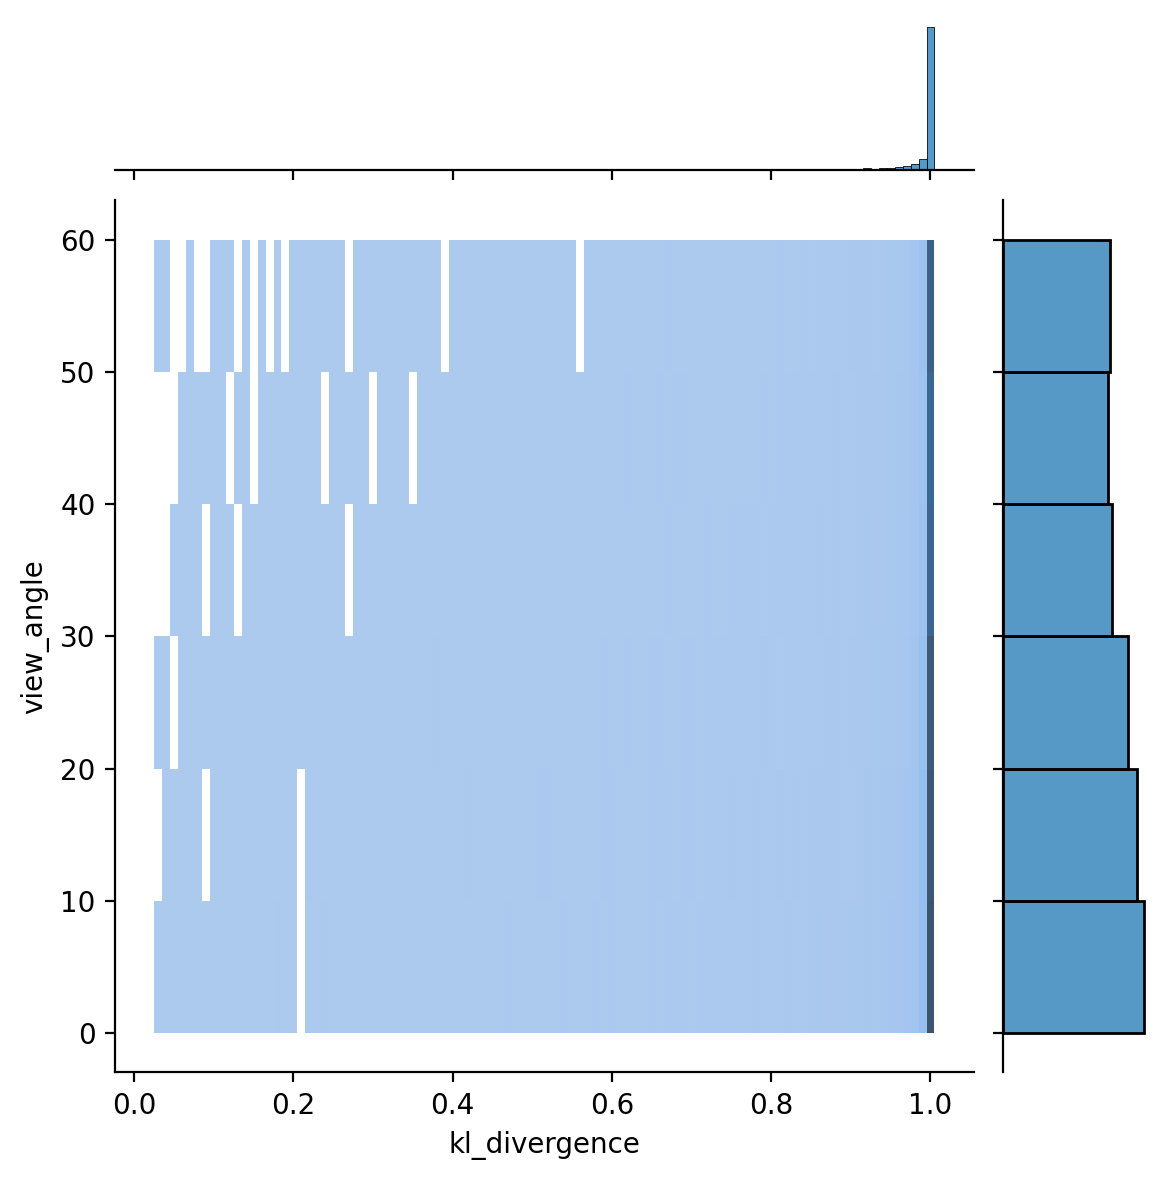

In [28]:
p = sns.jointplot(
    ellipse_matches,
    x = 'kl_divergence',
    y = 'view_angle',
    kind = 'hist',
    binwidth = ( 0.01, 10 ),
)

ValueError: Could not interpret value `view_angle` for parameter `y`

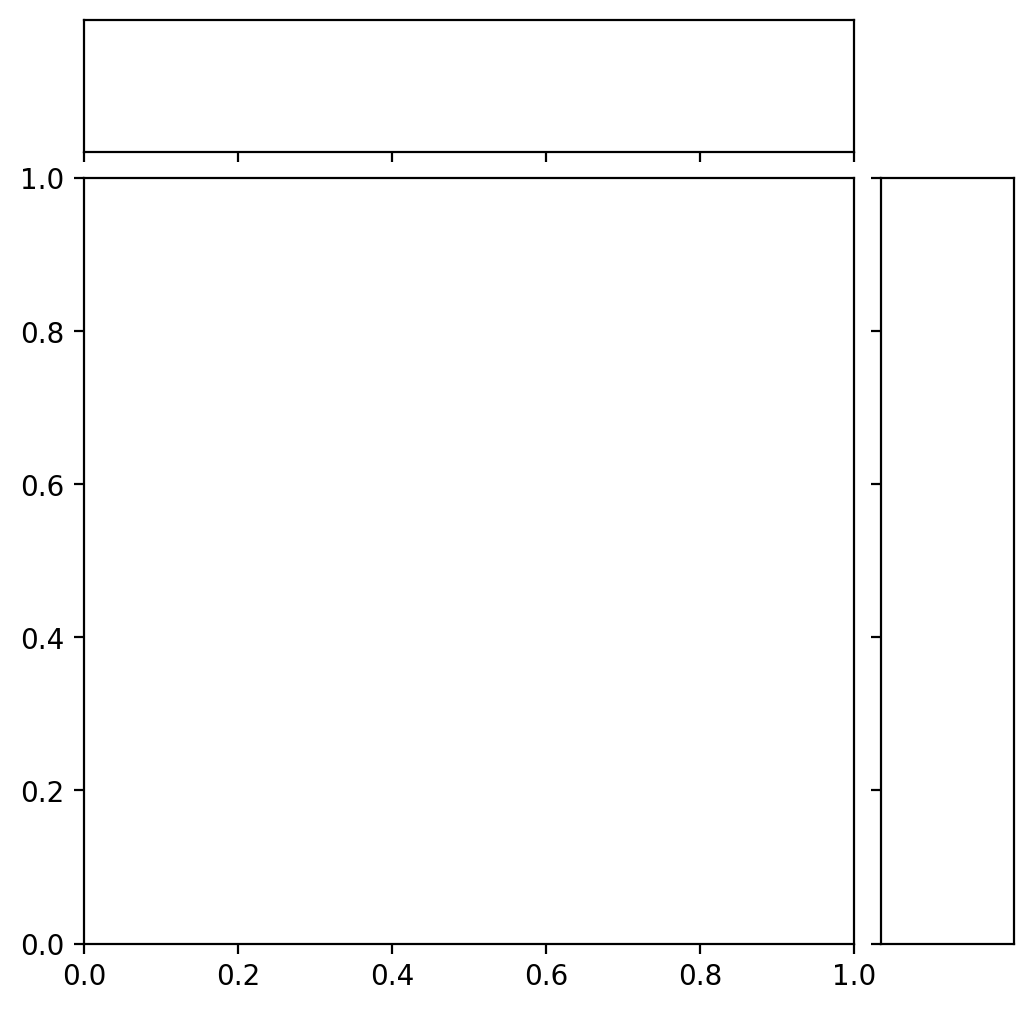

In [33]:
p = sns.jointplot(
    ellipse_matches,
    x = 'IoU',
    y = 'view_angle',
    kind = 'hist',
    binwidth = ( 0.01, 10 ),
)

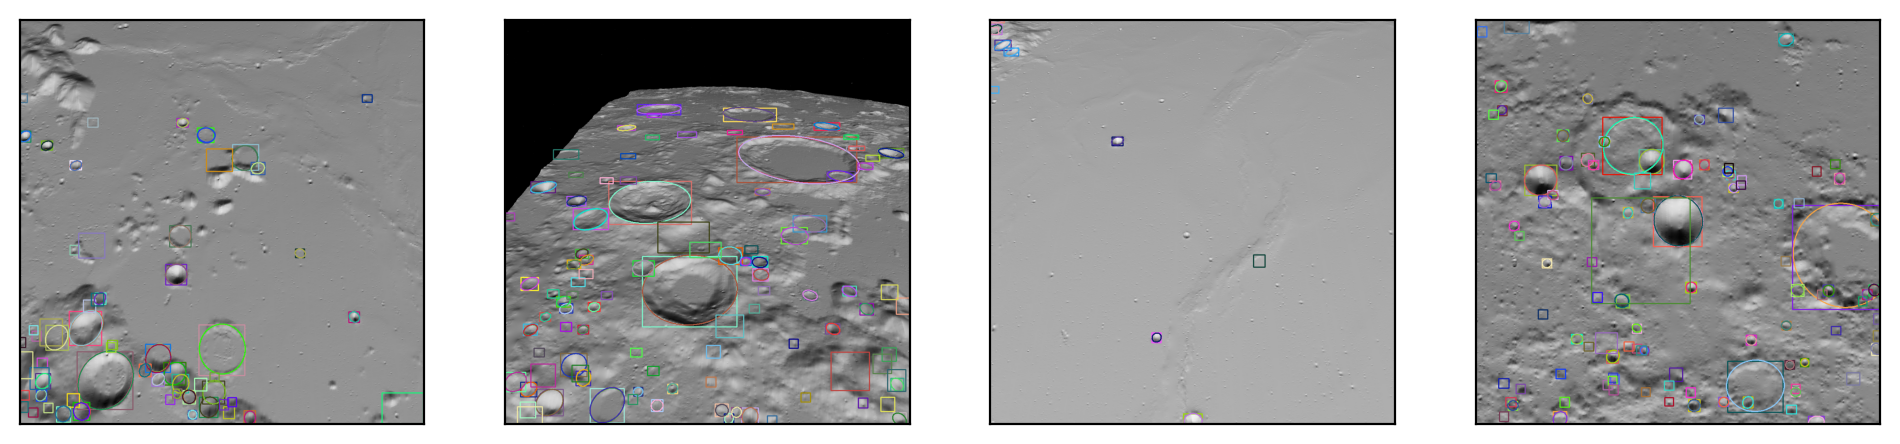

In [114]:
# Show a random sample of images
n_samples = 4
fig, ax = plt.subplots( ncols = n_samples )

for i in range( n_samples ):
    pred_index = int( np.random.rand() * len( predictions ) )
    img, target = dataset_test.__getitem__( pred_index )
    img = img.numpy()[0]
    img = np.stack( ( img, img, img ), axis = 2 )

    for bbox, ellipse in zip( predictions[pred_index]['boxes'], predictions[pred_index]['ellipse_sparse'] ):
        color = ( np.random.rand(), np.random.rand(), np.random.rand() )
        # Plot bounding box:
        cv2.rectangle(
            img,
            ( int( bbox[0] ), int( bbox[1] ) ),
            ( int( bbox[2] ), int( bbox[3] ) ),
            color,
            2,
        )
        
        # Plot ellipse:
        cv2.ellipse( 
            img,
            ( int( ellipse[0] ), int( ellipse[1] ) ), # Center point
            ( int( ellipse[2] / 2 ), int( ellipse[3] / 2 ) ), # Major and minor axes
            float( ellipse[4] * 180 / math.pi ), # Convert angle from radians to degrees
            0, # Start Angle for drawing
            360, # End Angle for drawing
            color,
            2,
        )
    
    ax[i].imshow( img )
    ax[i].set_xticks( [] )
    ax[i].set_yticks( [] )
    # ax[i].set_title( 'Angle: {angle:d}, Sample: {sample:d}'.format( angle = target['view_angle'][0].item(), sample = target['image_id'].item() ) )
plt.show()